# Elo world 

In this kernel, I build a LGBM model that aggregates the `new_merchant_transactions.csv` and `historical_transactions.csv` tables to the main train table. New features are built by successive grouping on`card_id` and `month_lag`, in order to recover some information from the time serie.

## Notebook  Content
1. [Loading the data](#1)
1. [Feature engineering](#2)
1. [Training the model](#3)
1. [Feature importance](#4)
1. [Submission](#5)

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
import time
import sys
import datetime
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)

<a id="1"></a> <br>
## 1. Loading the data

First, we load the `new_merchant_transactions.csv` and `historical_transactions.csv`. In practice, these two files contain the same variables and the difference between the two tables only concern the position with respect to a reference date.  Also, booleans features are made numeric:

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
new_transactions = pd.read_csv('../input/new_merchant_transactions.csv', parse_dates=['purchase_date'])
historical_transactions = pd.read_csv('../input/historical_transactions.csv', parse_dates=['purchase_date'])

def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

historical_transactions = binarize(historical_transactions)
new_transactions = binarize(new_transactions)

We then load the main files, formatting the dates and extracting the target:

In [4]:
def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df
#_________________________________________
train = read_data('../input/train.csv')
test = read_data('../input/test.csv')

target = train['target']
del train['target']

In [5]:
historical_transactions

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37
5,1,C_ID_4e6213e9bc,333,0,0,A,80,M_ID_50af771f8d,0,-0.734887,2018-02-24 08:45:05,1.0,9,37
6,1,C_ID_4e6213e9bc,88,0,0,A,278,M_ID_5e8220e564,-11,-0.716855,2017-03-21 00:10:51,1.0,16,37
7,1,C_ID_4e6213e9bc,3,0,0,A,80,M_ID_9d41786a50,-3,-0.657049,2017-11-18 20:05:55,1.0,16,37
8,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-8,-0.737967,2017-06-01 22:02:56,1.0,16,37
9,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_74ba14b5fc,-11,-0.715352,2017-03-16 15:41:22,1.0,16,37


In [6]:
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])

historical_transactions = reduce_mem_usage(historical_transactions)
new_transactions = reduce_mem_usage(new_transactions)

agg_fun = {'authorized_flag': ['sum', 'mean']}
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)

authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]

Mem. usage decreased to 1304.89 Mb (54.8% reduction)
Mem. usage decreased to 84.24 Mb (56.7% reduction)


In [7]:
historical_transactions[:5]

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C
115,0,C_ID_4e6213e9bc,88,0,0,842,M_ID_22c9cfa265,-10,-0.730379,2017-04-07 12:58:09,16,37,1,0,0,0,0,1,0,0
132,0,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-5,-0.723782,2017-09-17 22:40:27,16,16,1,0,0,0,0,1,0,0
148,0,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-5,-0.723782,2017-09-17 22:40:26,16,16,1,0,0,0,0,1,0,0
168,0,C_ID_4e6213e9bc,333,0,0,605,M_ID_c2ae34c2ef,0,-0.664262,2018-02-20 10:57:50,9,2,1,0,0,0,0,1,0,0
213,0,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-7,-0.738132,2017-07-08 07:33:31,16,34,1,0,0,0,0,1,0,0


<a id="2"></a> <br>
## Feature engineering
First, following [Robin Denz](https://www.kaggle.com/denzo123/a-closer-look-at-date-variables) analysis, I define a few dates features:

In [8]:
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month

Then I define two functions that aggregate the info contained in these two tables. The first function aggregates the function by grouping on `card_id`:

In [9]:
def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean'],
        'category_2_2.0': ['mean'],
        'category_2_3.0': ['mean'],
        'category_2_4.0': ['mean'],
        'category_2_5.0': ['mean'],
        'category_3_A': ['mean'],
        'category_3_B': ['mean'],
        'category_3_C': ['mean'],
        'merchant_id': ['nunique'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'city_id': ['nunique'],
        'subsector_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp, 'min', 'max'],
        'month_lag': ['min', 'max']
        }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

In [10]:
history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
history[:5]

,card_id,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,...,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_min,hist_month_lag_max
0,C_ID_00007093c1,35,4.0,0.114286,0.000000,0.000000,0.885714,0.0,0.000000,0.000000,...,0.667367,5.914286,12,1,3.071419,28858113.0,1.489250e+09,1.518108e+09,-11,0
1,C_ID_0001238066,3,0.0,0.000000,0.333333,0.000000,0.000000,0.0,0.666667,0.000000,...,0.000000,8.666667,12,2,5.773503,3609150.0,1.514660e+09,1.518269e+09,-2,0
2,C_ID_0001506ef0,4,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.750000,...,0.500000,5.500000,12,2,4.725816,22098875.0,1.496772e+09,1.518871e+09,-8,0
3,C_ID_0001793786,27,2.0,0.074074,0.111111,0.296296,0.111111,0.0,0.000000,0.814815,...,0.395847,6.481481,9,3,2.375684,16780236.0,1.488636e+09,1.505416e+09,-7,-1
4,C_ID_000183fdda,7,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,...,2.288689,8.285714,10,8,0.755929,6701589.0,1.502099e+09,1.508801e+09,-6,-4


In [11]:
authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]
authorized[:5]

,card_id,auth_transactions_count,auth_category_1_sum,auth_category_1_mean,auth_category_2_1.0_mean,auth_category_2_2.0_mean,auth_category_2_3.0_mean,auth_category_2_4.0_mean,auth_category_2_5.0_mean,auth_category_3_A_mean,...,auth_installments_std,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_month_lag_min,auth_month_lag_max
0,C_ID_00007093c1,114,24.0,0.210526,0.000000,0.000000,0.780702,0.0,0.008772,0.0,...,0.795159,6.517544,12,1,3.371490,32627654.0,1.487081e+09,1.519708e+09,-12,0
1,C_ID_0001238066,120,2.0,0.016667,0.783333,0.000000,0.000000,0.0,0.150000,0.0,...,1.501050,7.275000,12,1,4.895483,13110825.0,1.506638e+09,1.519748e+09,-5,0
2,C_ID_0001506ef0,62,0.0,0.000000,0.032258,0.000000,0.967742,0.0,0.000000,1.0,...,0.000000,6.887097,12,1,4.538017,34460275.0,1.484411e+09,1.518871e+09,-13,0
3,C_ID_0001793786,189,0.0,0.000000,0.042328,0.359788,0.063492,0.0,0.000000,1.0,...,0.000000,6.698413,10,1,2.301491,24487497.0,1.484994e+09,1.509481e+09,-9,0
4,C_ID_000183fdda,137,4.0,0.029197,0.051095,0.007299,0.905109,0.0,0.007299,0.0,...,2.108912,6.810219,12,1,4.538289,15148616.0,1.504444e+09,1.519592e+09,-5,0


In [12]:
new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
new[:5]

,card_id,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,...,new_installments_std,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_min,new_month_lag_max
0,C_ID_00007093c1,2,0,0.000000,0.500000,0.000000,0.50000,0.0,0.000000,0.0,...,0.000000,4.000000,4,4,0.000000,537024.0,1.522754e+09,1.523291e+09,2,2
1,C_ID_0001238066,26,2,0.076923,0.769231,0.000000,0.00000,0.0,0.115385,0.0,...,2.079941,3.346154,4,3,0.485165,5195343.0,1.519923e+09,1.525118e+09,1,2
2,C_ID_0001506ef0,2,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,1.0,...,0.000000,3.000000,3,3,0.000000,471152.0,1.521239e+09,1.521710e+09,1,1
3,C_ID_0001793786,31,0,0.000000,0.483871,0.258065,0.16129,0.0,0.032258,1.0,...,0.000000,11.322581,12,11,0.475191,3981096.0,1.510761e+09,1.514742e+09,1,2
4,C_ID_000183fdda,11,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,0.0,...,1.293340,3.272727,4,3,0.467099,5106807.0,1.519994e+09,1.525100e+09,1,2


The second function first aggregates on the two variables `card_id` and `month_lag`. Then a second grouping is performed to aggregate over time:

In [13]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group
#___________________________________________________________
final_group =  aggregate_per_month(historical_transactions) 
final_group[:10]

,card_id,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,...,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,C_ID_00007093c1,-5.500000,3.605551,2.916667,1.621354,-1.200164,0.999049,-0.431906,0.260478,-0.613764,...,3.750000,3.107908,1.176389,0.326634,1.000000,0.000000,1.500000,0.797724,0.355262,0.480551
1,C_ID_0001238066,-1.000000,1.414214,1.500000,0.707107,-0.894964,0.421890,-0.596643,0.000000,-0.596643,...,1.500000,0.707107,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,NaN
2,C_ID_0001506ef0,-3.333333,4.163332,1.333333,0.577350,-0.968594,0.395645,-0.731020,0.015849,-0.732397,...,0.333333,0.577350,0.166667,0.288675,0.000000,0.000000,0.333333,0.577350,0.707107,NaN
3,C_ID_0001793786,-3.833333,2.316607,4.500000,1.974842,-1.970890,2.037261,-0.423501,0.392159,-0.676499,...,0.833333,0.983192,0.291667,0.400520,0.166667,0.408248,0.500000,0.547723,0.179558,0.279244
4,C_ID_000183fdda,-5.000000,1.414214,3.500000,3.535534,-0.470690,0.344856,-0.376174,0.478523,-0.579708,...,9.500000,12.020815,2.000000,1.414214,1.000000,0.000000,3.500000,3.535534,2.366432,NaN
5,C_ID_00024e244b,-5.000000,4.000000,2.428571,1.397276,-1.186659,1.210810,-0.558085,0.326273,-0.607249,...,0.714286,1.112697,0.297619,0.419041,0.142857,0.377964,0.428571,0.534522,0.269338,0.312603
6,C_ID_0002709b5a,-7.250000,5.057997,1.500000,1.000000,-0.929675,0.699316,-0.604163,0.156637,-0.616865,...,2.750000,2.362908,2.250000,2.500000,2.250000,2.500000,2.250000,2.500000,0.000000,NaN
7,C_ID_00027503e2,-4.000000,2.915476,3.600000,1.516575,-2.669652,1.128393,-0.741249,0.002457,-0.742989,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,C_ID_000298032a,-6.500000,3.535534,1.000000,0.000000,-0.617958,0.093896,-0.617958,0.093896,-0.617958,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
9,C_ID_0002ba3c2e,-3.666667,3.559026,2.500000,1.516575,-1.547448,0.910264,-0.641704,0.080430,-0.655965,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<a id="3"></a> <br>
## 3. Training the model
We now train the model with the features we previously defined. A first step consists in merging all the dataframes:

In [14]:
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, authorized, on='card_id', how='left')
test = pd.merge(test, authorized, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

train = pd.merge(train, auth_mean, on='card_id', how='left')
test = pd.merge(test, auth_mean, on='card_id', how='left')

and to define the features we want to keep to train the model:

In [37]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = [c for c in features if 'feature_' in c]

We then set the hyperparameters of the LGBM model:

In [16]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True
evals_result = {}

In [17]:
params = {'num_leaves': 100,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': 6,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1}

In [18]:
train['outliers'] = 0
train.loc[target < -30, 'outliers'] = 1
train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

We now train the model. Here, we use a standard KFold split of the dataset in order to validate the results and to stop the training. Interstingly, during the writing of this kernel, the model was enriched adding new features, which improved the CV score. The variations observed on the CV were found to be quite similar to the variations on the LB: it seems that the current competition won't give us headaches to define the correct validation scheme:

In [19]:
train[features]

,feature_1,feature_2,feature_3,elapsed_time,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,...,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std,authorized_flag_sum,authorized_flag_mean
0,5,2,1,245,13.0,0.0,0.000000,1.000000,0.0,0.000000,...,0.319444,0.423007,0.166667,0.408248,0.500000,0.547723,0.269338,0.312603,247.0,0.950000
1,4,1,0,396,11.0,2.0,0.181818,0.818182,0.0,0.000000,...,4.033333,3.522310,3.500000,3.728270,5.000000,4.289522,1.781853,2.519921,339.0,0.968571
2,2,2,0,549,2.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,41.0,0.953488
3,4,3,0,153,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.0,1.000000
4,1,3,0,92,5.0,3.0,0.600000,0.000000,0.0,0.000000,...,6.500000,7.778175,6.500000,7.778175,6.500000,7.778175,0.000000,0.000000,128.0,0.962406
5,4,2,0,518,1.0,0.0,0.000000,1.000000,0.0,0.000000,...,1.000000,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN,32.0,0.969697
6,3,2,1,427,17.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,243.0,0.934615
7,3,2,1,153,3.0,0.0,0.000000,0.333333,0.0,0.000000,...,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,19.0,0.863636
8,2,1,0,184,4.0,4.0,1.000000,0.000000,0.0,0.000000,...,1.000000,NaN,1.000000,NaN,1.000000,NaN,0.000000,NaN,11.0,0.733333
9,2,2,0,549,14.0,0.0,0.000000,1.000000,0.0,0.000000,...,0.125000,0.306186,0.000000,0.000000,0.166667,0.408248,0.166667,0.288675,99.0,0.876106


In [56]:
train_embed = pd.read_csv("train_embed.csv")
test_embed = pd.read_csv("test_embed.csv")

In [65]:
train_embed["embed"] = train_embed["embed"].apply(ast.literal_eval)

In [26]:
train = train.drop(categorical_feats, axis = 1)
test = test.drop(categorical_feats, axis = 1)

In [81]:
train = pd.merge(train, train_embed, on='card_id', how='left')
test = pd.merge(test, test_embed, on='card_id', how='left')

In [91]:
embed_features = train['embed'].apply(pd.Series).columns
train = pd.concat([train, train['embed'].apply(pd.Series)], axis = 1)
train = train.drop("embed", axis = 1)

In [95]:
test = pd.concat([test, test['embed'].apply(pd.Series)], axis = 1)
test = test.drop("embed", axis = 1)

In [92]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]

In [ ]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, train["outliers"].values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=train["outliers"].iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=train["outliers"].iloc[val_idx])

    num_round = 1000
    clf = lgb.train(params,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                   early_stopping_rounds = 200,
#                     feval=lgb_f1_score,
#                     evals_result=evals_result
                   )
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 0.066293	valid_1's rmse: 0.0663835
[200]	training's rmse: 0.0422878	valid_1's rmse: 0.0423772
[300]	training's rmse: 0.0266138	valid_1's rmse: 0.0266982
[400]	training's rmse: 0.0168463	valid_1's rmse: 0.0169311


In [71]:
# features.append("embed")
np.array(train["embed"]).shape

(201917,)

In [75]:
train["embed"].values[0][0]

'['

In [79]:
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, train["outliers"].values)):
    if fold_ > 0:
        continue
    val_idx1 = val_idx


In [114]:
train["outliers"].iloc[val_idx1].value_counts()

0    39942
1      442
Name: outliers, dtype: int64

In [ ]:
import ast
ast.literal_eval(train["embed"].tolist())[0]

In [124]:
oof1 = oof

In [115]:
f1, precision, recall = [], [], []
thresh_range = np.arange(0, 1, .01)
for threshold in thresh_range:
    oof_thresholded = [0 if a_ > threshold else 1 for a_ in oof[val_idx1]]
    f1.append(f1_score(oof_thresholded, train["outliers"].iloc[val_idx1]))
    precision.append(precision_score(oof_thresholded, train["outliers"].iloc[val_idx1]))
    recall.append(recall_score(oof_thresholded, train["outliers"].iloc[val_idx1]))


c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


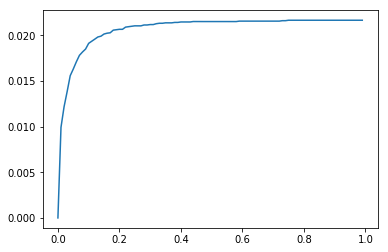

In [116]:
plt.plot(thresh_range, f1)

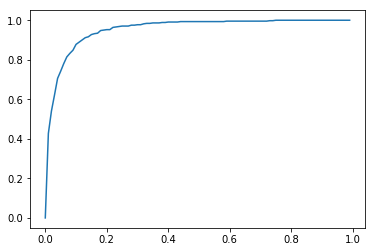

In [117]:
plt.plot(thresh_range, precision)

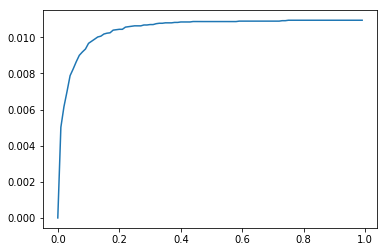

In [118]:
plt.plot(thresh_range, recall)

In [135]:
oof_thresholded = [1 if a_ > .000001 else 0 for a_ in oof[val_idx1]]
cnf_matrix = confusion_matrix(oof_thresholded, train["outliers"].iloc[val_idx1])
cnf_matrix.ravel()

array([  153,     0, 39789,   442], dtype=int64)

array([39939,   439,     3,     3], dtype=int64)

tn, fp, fn, tp

<a id="4"></a> <br>
## 4. Feature importance
Finally, we can have a look at the features that were used by the model:

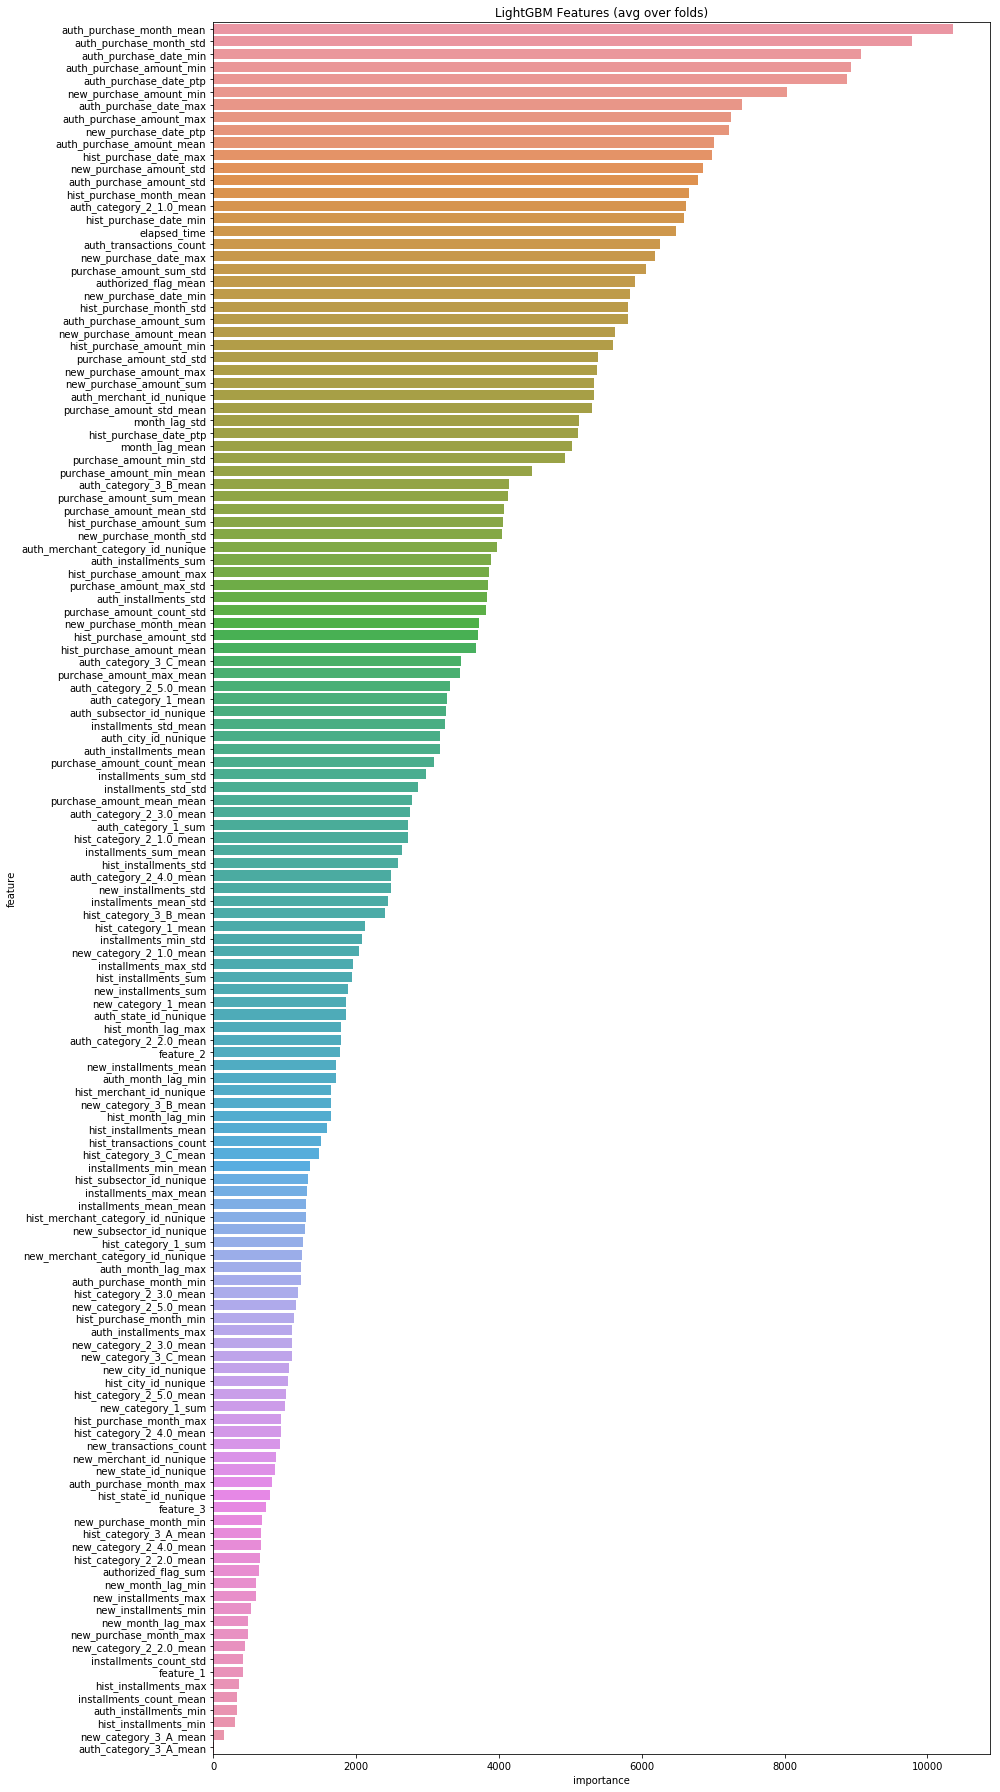

In [82]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

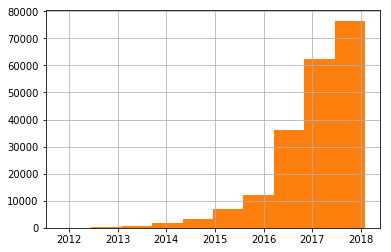

In [53]:

train[train["outliers"] == True][train.columns[0]].hist()
train[train["outliers"] == False][train.columns[0]].hist()

<a id="5"></a> <br>
## 5. Submission
Now, we just need to prepare the submission file:

In [18]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submit.csv", index=False)

In [22]:
from bayes_opt import BayesianOptimization

In [30]:
def lgbm_eval(num_leaves,
              colsample_bytree,
              min_data_in_leaf,
              subsample,
              max_depth,
              reg_alpha,
              reg_lambda,
              min_split_gain,
              min_child_weight,
              min_child_samples,
              feature_fraction,
              bagging_freq,
              bagging_fraction
             ):
    params["num_leaves"] = int(num_leaves)
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['subsample'] = max(min(subsample, 1), 0)
    params['max_depth'] = int(max_depth)
    params['reg_alpha'] = max(reg_alpha, 0)
    params['reg_lambda'] = max(reg_lambda, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    params["min_data_in_leaf"] = int(min_data_in_leaf)
    params["min_child_samples"] = min_child_samples
    params["feature_fraction"] = feature_fraction
    params["bagging_freq"] = int(bagging_freq)
    params["bagging_fraction"] = bagging_fraction

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
        trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
        val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)

        num_round = 10000
        clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 200)
        oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    
    return -mean_squared_error(oof, target)**0.5


clf_bo = BayesianOptimization(lgbm_eval, {'num_leaves': (30, 45),
                                          'colsample_bytree': (0.1, 1),
                                          'min_data_in_leaf': (10,100), 
                                          'subsample': (0.1, 1),
                                          'max_depth': (5, 15),
                                          'reg_alpha': (0, 10),
                                          'reg_lambda': (0, 10),
                                          'min_split_gain': (0, 1),
                                          'min_child_weight': (30, 45),
                                          "min_child_samples": (5,50),
                                          "feature_fraction": (0.1,0.95),
                                          "bagging_freq": (0, 20),
                                          "bagging_fraction": (.01, .99)
                                        })

clf_bo.maximize(init_points=50, n_iter=200)

Initialization
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   bagging_freq |   colsample_bytree |   feature_fraction |   max_depth |   min_child_samples |   min_child_weight |   min_data_in_leaf |   min_split_gain |   num_leaves |   reg_alpha |   reg_lambda |   subsample | 


c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60957	valid_1's rmse: 3.71282
[1000]	training's rmse: 3.5423	valid_1's rmse: 3.69211
[1500]	training's rmse: 3.49252	valid_1's rmse: 3.68575
[2000]	training's rmse: 3.45004	valid_1's rmse: 3.68396
[2500]	training's rmse: 3.4107	valid_1's rmse: 3.68399
Early stopping, best iteration is:
[2399]	training's rmse: 3.41788	valid_1's rmse: 3.68292
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.62147	valid_1's rmse: 3.65169
[1000]	training's rmse: 3.55137	valid_1's rmse: 3.63536
[1500]	training's rmse: 3.50277	valid_1's rmse: 3.63069
[2000]	training's rmse: 3.45954	valid_1's rmse: 3.62792
Early stopping, best iteration is:
[2257]	training's rmse: 3.43808	valid_1's rmse: 3.62706
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.62608	valid_1's rmse: 3.62875
[1000]	training's rmse: 3.55656	valid_1's rmse: 3.6121
[1500]	training's r

[2500]	training's rmse: 3.42352	valid_1's rmse: 3.68209
[3000]	training's rmse: 3.39343	valid_1's rmse: 3.68134
[3500]	training's rmse: 3.36415	valid_1's rmse: 3.68078
[4000]	training's rmse: 3.33692	valid_1's rmse: 3.68062
Early stopping, best iteration is:
[3940]	training's rmse: 3.34026	valid_1's rmse: 3.68052
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.62513	valid_1's rmse: 3.6542
[1000]	training's rmse: 3.55234	valid_1's rmse: 3.63491
[1500]	training's rmse: 3.5052	valid_1's rmse: 3.62819
[2000]	training's rmse: 3.46664	valid_1's rmse: 3.62563
[2500]	training's rmse: 3.43301	valid_1's rmse: 3.62409
[3000]	training's rmse: 3.40225	valid_1's rmse: 3.62363
Early stopping, best iteration is:
[3049]	training's rmse: 3.39948	valid_1's rmse: 3.62335
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.62989	valid_1's rmse: 3.63109
[1000]	training's rmse: 3.55782	valid_1's rmse: 3.61209
[1500]	training's rmse: 

[500]	training's rmse: 3.57911	valid_1's rmse: 3.80825
[1000]	training's rmse: 3.52088	valid_1's rmse: 3.79589
[1500]	training's rmse: 3.47961	valid_1's rmse: 3.79298
[2000]	training's rmse: 3.44484	valid_1's rmse: 3.79243
Early stopping, best iteration is:
[2165]	training's rmse: 3.43297	valid_1's rmse: 3.7921
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.62175	valid_1's rmse: 3.63884
[1000]	training's rmse: 3.56325	valid_1's rmse: 3.62723
[1500]	training's rmse: 3.52257	valid_1's rmse: 3.62478
Early stopping, best iteration is:
[1672]	training's rmse: 3.50911	valid_1's rmse: 3.62438
    7 | 03m11s |   -3.66549 |             0.5916 |         2.6548 |             0.1684 |             0.8102 |      7.0195 |             37.8373 |            39.5031 |            85.4895 |           0.5238 |      42.8043 |      5.1800 |       2.0286 |      0.8079 | 
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.6328	valid_1

Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.6325	valid_1's rmse: 3.71201
[1000]	training's rmse: 3.58244	valid_1's rmse: 3.69654
[1500]	training's rmse: 3.54477	valid_1's rmse: 3.69204
[2000]	training's rmse: 3.51317	valid_1's rmse: 3.69016
Early stopping, best iteration is:
[1910]	training's rmse: 3.51845	valid_1's rmse: 3.68983
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64625	valid_1's rmse: 3.65336
[1000]	training's rmse: 3.59482	valid_1's rmse: 3.64065
[1500]	training's rmse: 3.55823	valid_1's rmse: 3.63575
[2000]	training's rmse: 3.52659	valid_1's rmse: 3.63289
Early stopping, best iteration is:
[2072]	training's rmse: 3.52226	valid_1's rmse: 3.63211
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64873	valid_1's rmse: 3.62548
[1000]	training's rmse: 3.59676	valid_1's rmse: 3.61335
[1500]	training's rmse: 3.55767	valid_1's rmse: 3.6114
Early stopping, be

[1500]	training's rmse: 3.60116	valid_1's rmse: 3.69507
[2000]	training's rmse: 3.57999	valid_1's rmse: 3.69093
[2500]	training's rmse: 3.56005	valid_1's rmse: 3.68711
[3000]	training's rmse: 3.54211	valid_1's rmse: 3.68552
[3500]	training's rmse: 3.5248	valid_1's rmse: 3.68497
Early stopping, best iteration is:
[3351]	training's rmse: 3.52969	valid_1's rmse: 3.68477
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.68253	valid_1's rmse: 3.66624
[1000]	training's rmse: 3.63982	valid_1's rmse: 3.64628
[1500]	training's rmse: 3.61303	valid_1's rmse: 3.63818
[2000]	training's rmse: 3.59157	valid_1's rmse: 3.63383
[2500]	training's rmse: 3.57328	valid_1's rmse: 3.63201
[3000]	training's rmse: 3.55551	valid_1's rmse: 3.62998
[3500]	training's rmse: 3.53818	valid_1's rmse: 3.62872
[4000]	training's rmse: 3.52181	valid_1's rmse: 3.62788
[4500]	training's rmse: 3.5055	valid_1's rmse: 3.62709
[5000]	training's rmse: 3.49041	valid_1's rmse: 3.62655
[5500]	tr

[2000]	training's rmse: 3.46669	valid_1's rmse: 3.63109
[2500]	training's rmse: 3.42711	valid_1's rmse: 3.63134
Early stopping, best iteration is:
[2359]	training's rmse: 3.43832	valid_1's rmse: 3.63069
   17 | 02m13s |   -3.66972 |             0.4504 |         4.9576 |             0.3511 |             0.3070 |     10.8493 |             41.1802 |            37.0603 |            56.4156 |           0.9501 |      40.4725 |      6.6928 |       7.5959 |      0.5425 | 
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.6159	valid_1's rmse: 3.72471
[1000]	training's rmse: 3.53417	valid_1's rmse: 3.7003
[1500]	training's rmse: 3.47943	valid_1's rmse: 3.69166
[2000]	training's rmse: 3.43336	valid_1's rmse: 3.68818
[2500]	training's rmse: 3.39099	valid_1's rmse: 3.68614
[3000]	training's rmse: 3.35153	valid_1's rmse: 3.68479
[3500]	training's rmse: 3.31442	valid_1's rmse: 3.6847
Early stopping, best iteration is:
[3329]	training's rmse: 3.32684	valid_1's rms

[2500]	training's rmse: 3.53147	valid_1's rmse: 3.63443
Early stopping, best iteration is:
[2670]	training's rmse: 3.52307	valid_1's rmse: 3.63409
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.68134	valid_1's rmse: 3.64472
[1000]	training's rmse: 3.62785	valid_1's rmse: 3.62703
[1500]	training's rmse: 3.59133	valid_1's rmse: 3.62242
[2000]	training's rmse: 3.55972	valid_1's rmse: 3.62042
Early stopping, best iteration is:
[2165]	training's rmse: 3.55116	valid_1's rmse: 3.61948
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.63488	valid_1's rmse: 3.84218
[1000]	training's rmse: 3.58084	valid_1's rmse: 3.82015
[1500]	training's rmse: 3.54416	valid_1's rmse: 3.81282
[2000]	training's rmse: 3.51556	valid_1's rmse: 3.80906
[2500]	training's rmse: 3.48814	valid_1's rmse: 3.80657
[3000]	training's rmse: 3.46237	valid_1's rmse: 3.80604
Early stopping, best iteration is:
[2838]	training's rmse: 3.47053	valid_1's r

Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.68237	valid_1's rmse: 3.6487
[1000]	training's rmse: 3.62057	valid_1's rmse: 3.62799
[1500]	training's rmse: 3.5807	valid_1's rmse: 3.62101
[2000]	training's rmse: 3.54607	valid_1's rmse: 3.61963
[2500]	training's rmse: 3.51421	valid_1's rmse: 3.61848
Early stopping, best iteration is:
[2306]	training's rmse: 3.52694	valid_1's rmse: 3.61833
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.63576	valid_1's rmse: 3.84683
[1000]	training's rmse: 3.57572	valid_1's rmse: 3.82252
[1500]	training's rmse: 3.53413	valid_1's rmse: 3.81503
[2000]	training's rmse: 3.49971	valid_1's rmse: 3.81141
[2500]	training's rmse: 3.46729	valid_1's rmse: 3.80939
[3000]	training's rmse: 3.43711	valid_1's rmse: 3.80797
Early stopping, best iteration is:
[2847]	training's rmse: 3.44604	valid_1's rmse: 3.80767
Training until validation scores don't improve for 200 rounds.
[500]	training's 

Early stopping, best iteration is:
[2685]	training's rmse: 3.41425	valid_1's rmse: 3.68169
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.63089	valid_1's rmse: 3.65555
[1000]	training's rmse: 3.55981	valid_1's rmse: 3.63579
[1500]	training's rmse: 3.5128	valid_1's rmse: 3.62888
[2000]	training's rmse: 3.47316	valid_1's rmse: 3.62643
[2500]	training's rmse: 3.43827	valid_1's rmse: 3.62521
[3000]	training's rmse: 3.40606	valid_1's rmse: 3.62466
[3500]	training's rmse: 3.37418	valid_1's rmse: 3.62417
Early stopping, best iteration is:
[3682]	training's rmse: 3.36308	valid_1's rmse: 3.62364
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.63563	valid_1's rmse: 3.63124
[1000]	training's rmse: 3.56517	valid_1's rmse: 3.61237
[1500]	training's rmse: 3.51741	valid_1's rmse: 3.6073
[2000]	training's rmse: 3.47804	valid_1's rmse: 3.60523
Early stopping, best iteration is:
[2101]	training's rmse: 3.47082	valid_1's rms

Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.66656	valid_1's rmse: 3.74014
[1000]	training's rmse: 3.60371	valid_1's rmse: 3.71153
[1500]	training's rmse: 3.56143	valid_1's rmse: 3.70091
[2000]	training's rmse: 3.52665	valid_1's rmse: 3.69536
[2500]	training's rmse: 3.49472	valid_1's rmse: 3.69294
[3000]	training's rmse: 3.4655	valid_1's rmse: 3.69124
[3500]	training's rmse: 3.43753	valid_1's rmse: 3.69059
Early stopping, best iteration is:
[3623]	training's rmse: 3.43067	valid_1's rmse: 3.68998
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.68254	valid_1's rmse: 3.67719
[1000]	training's rmse: 3.61832	valid_1's rmse: 3.65296
[1500]	training's rmse: 3.57528	valid_1's rmse: 3.6428
[2000]	training's rmse: 3.53942	valid_1's rmse: 3.63739
[2500]	training's rmse: 3.50731	valid_1's rmse: 3.63429
[3000]	training's rmse: 3.47865	valid_1's rmse: 3.63278
[3500]	training's rmse: 3.45037	valid_1's rmse: 3.63228
[40

[1000]	training's rmse: 3.65053	valid_1's rmse: 3.72157
[1500]	training's rmse: 3.62664	valid_1's rmse: 3.71408
[2000]	training's rmse: 3.60404	valid_1's rmse: 3.70832
Early stopping, best iteration is:
[2184]	training's rmse: 3.59701	valid_1's rmse: 3.70762
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.70115	valid_1's rmse: 3.67413
[1000]	training's rmse: 3.66287	valid_1's rmse: 3.65782
[1500]	training's rmse: 3.63871	valid_1's rmse: 3.65093
[2000]	training's rmse: 3.61827	valid_1's rmse: 3.64921
Early stopping, best iteration is:
[1824]	training's rmse: 3.62441	valid_1's rmse: 3.64788
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.70972	valid_1's rmse: 3.65238
[1000]	training's rmse: 3.66897	valid_1's rmse: 3.63683
[1500]	training's rmse: 3.64489	valid_1's rmse: 3.63397
[2000]	training's rmse: 3.6241	valid_1's rmse: 3.63199
Early stopping, best iteration is:
[1832]	training's rmse: 3.63074	valid_1's rm

Early stopping, best iteration is:
[1906]	training's rmse: 3.48282	valid_1's rmse: 3.60679
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.58123	valid_1's rmse: 3.8122
[1000]	training's rmse: 3.51652	valid_1's rmse: 3.79577
[1500]	training's rmse: 3.47226	valid_1's rmse: 3.79274
Early stopping, best iteration is:
[1454]	training's rmse: 3.47628	valid_1's rmse: 3.79261
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61843	valid_1's rmse: 3.6443
[1000]	training's rmse: 3.55354	valid_1's rmse: 3.62993
[1500]	training's rmse: 3.50987	valid_1's rmse: 3.62506
Early stopping, best iteration is:
[1771]	training's rmse: 3.48805	valid_1's rmse: 3.62431
   37 | 02m55s |   -3.66793 |             0.8865 |        16.9529 |             0.1413 |             0.7843 |      7.2846 |              9.5609 |            42.1854 |            32.7484 |           0.6050 |      32.9459 |      2.2513 |       3.9613 |      0.2200 | 
Tra

[500]	training's rmse: 3.69432	valid_1's rmse: 3.66438
[1000]	training's rmse: 3.65882	valid_1's rmse: 3.64774
[1500]	training's rmse: 3.63609	valid_1's rmse: 3.6412
[2000]	training's rmse: 3.61658	valid_1's rmse: 3.63787
[2500]	training's rmse: 3.59953	valid_1's rmse: 3.63647
[3000]	training's rmse: 3.5843	valid_1's rmse: 3.63467
Early stopping, best iteration is:
[3000]	training's rmse: 3.5843	valid_1's rmse: 3.63467
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.69845	valid_1's rmse: 3.64078
[1000]	training's rmse: 3.66336	valid_1's rmse: 3.62508
[1500]	training's rmse: 3.64067	valid_1's rmse: 3.62002
[2000]	training's rmse: 3.62021	valid_1's rmse: 3.61732
[2500]	training's rmse: 3.6027	valid_1's rmse: 3.61605
[3000]	training's rmse: 3.58622	valid_1's rmse: 3.61515
Early stopping, best iteration is:
[3032]	training's rmse: 3.58525	valid_1's rmse: 3.61475
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.6

Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61186	valid_1's rmse: 3.65121
[1000]	training's rmse: 3.53505	valid_1's rmse: 3.63301
[1500]	training's rmse: 3.48297	valid_1's rmse: 3.62687
[2000]	training's rmse: 3.44111	valid_1's rmse: 3.62446
[2500]	training's rmse: 3.40363	valid_1's rmse: 3.62368
Early stopping, best iteration is:
[2591]	training's rmse: 3.39746	valid_1's rmse: 3.62345
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61667	valid_1's rmse: 3.62779
[1000]	training's rmse: 3.5397	valid_1's rmse: 3.60999
[1500]	training's rmse: 3.48842	valid_1's rmse: 3.60568
[2000]	training's rmse: 3.44574	valid_1's rmse: 3.60398
Early stopping, best iteration is:
[2205]	training's rmse: 3.42993	valid_1's rmse: 3.60351
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.57136	valid_1's rmse: 3.81492
[1000]	training's rmse: 3.49409	valid_1's rmse: 3.797
[1500]	training's r

[500]	training's rmse: 3.59781	valid_1's rmse: 3.81627
[1000]	training's rmse: 3.54685	valid_1's rmse: 3.80688
[1500]	training's rmse: 3.50939	valid_1's rmse: 3.80407
[2000]	training's rmse: 3.47814	valid_1's rmse: 3.80128
Early stopping, best iteration is:
[2030]	training's rmse: 3.47634	valid_1's rmse: 3.80099
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64022	valid_1's rmse: 3.64493
[1000]	training's rmse: 3.58786	valid_1's rmse: 3.63613
[1500]	training's rmse: 3.55202	valid_1's rmse: 3.63401
Early stopping, best iteration is:
[1300]	training's rmse: 3.56554	valid_1's rmse: 3.6337
   47 | 01m58s |   -3.67391 |             0.2054 |         7.7924 |             0.6518 |             0.8377 |      7.1868 |             40.2802 |            40.3178 |            31.9895 |           0.3740 |      42.5542 |      6.8890 |       8.3958 |      0.2781 | 
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60331	valid_

[1000]	training's rmse: 3.52304	valid_1's rmse: 3.68914
[1500]	training's rmse: 3.47419	valid_1's rmse: 3.68334
[2000]	training's rmse: 3.43646	valid_1's rmse: 3.68216
[2500]	training's rmse: 3.40322	valid_1's rmse: 3.68183
Early stopping, best iteration is:
[2379]	training's rmse: 3.41091	valid_1's rmse: 3.68158
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.609	valid_1's rmse: 3.64998
[1000]	training's rmse: 3.53478	valid_1's rmse: 3.63241
[1500]	training's rmse: 3.48631	valid_1's rmse: 3.62783
[2000]	training's rmse: 3.44698	valid_1's rmse: 3.62618
[2500]	training's rmse: 3.4128	valid_1's rmse: 3.62568
Early stopping, best iteration is:
[2324]	training's rmse: 3.42462	valid_1's rmse: 3.62561
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61339	valid_1's rmse: 3.62615
[1000]	training's rmse: 3.5395	valid_1's rmse: 3.60864
[1500]	training's rmse: 3.49113	valid_1's rmse: 3.60426
[2000]	training's rmse: 3.

Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.59359	valid_1's rmse: 3.70726
[1000]	training's rmse: 3.51797	valid_1's rmse: 3.68782
[1500]	training's rmse: 3.46332	valid_1's rmse: 3.68378
[2000]	training's rmse: 3.41636	valid_1's rmse: 3.68234
Early stopping, best iteration is:
[1938]	training's rmse: 3.42177	valid_1's rmse: 3.68219
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60651	valid_1's rmse: 3.64874
[1000]	training's rmse: 3.52924	valid_1's rmse: 3.63136
[1500]	training's rmse: 3.475	valid_1's rmse: 3.62586
[2000]	training's rmse: 3.42733	valid_1's rmse: 3.62423
Early stopping, best iteration is:
[2023]	training's rmse: 3.4252	valid_1's rmse: 3.62415
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61157	valid_1's rmse: 3.62489
[1000]	training's rmse: 3.53426	valid_1's rmse: 3.60837
[1500]	training's rmse: 3.47987	valid_1's rmse: 3.60493
[2000]	training's r

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00016657]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.5983	valid_1's rmse: 3.70573
[1000]	training's rmse: 3.52925	valid_1's rmse: 3.68813
[1500]	training's rmse: 3.47959	valid_1's rmse: 3.6843
[2000]	training's rmse: 3.43595	valid_1's rmse: 3.68326
Early stopping, best iteration is:
[1871]	training's rmse: 3.44679	valid_1's rmse: 3.683
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61267	valid_1's rmse: 3.64809
[1000]	training's rmse: 3.54205	valid_1's rmse: 3.63322
[1500]	training's rmse: 3.49187	valid_1's rmse: 3.62837
Early stopping, best iteration is:
[1570]	training's rmse: 3.48537	valid_1's rmse: 3.62783
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61722	valid_1's rmse: 3.624
[1000]	training's rmse: 3.54737	valid_1's rmse: 3.60883
[1500]	training's rmse: 3.49634	valid_1's rmse: 3.6057
Early stopping, best iteration is:
[1518]	training's rmse: 3.49452	valid_1's rm

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00035435]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.6139	valid_1's rmse: 3.7071
[1000]	training's rmse: 3.55786	valid_1's rmse: 3.68804
[1500]	training's rmse: 3.51867	valid_1's rmse: 3.68314
[2000]	training's rmse: 3.48635	valid_1's rmse: 3.6815
[2500]	training's rmse: 3.45328	valid_1's rmse: 3.68039
Early stopping, best iteration is:
[2533]	training's rmse: 3.45074	valid_1's rmse: 3.68026
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.62853	valid_1's rmse: 3.64749
[1000]	training's rmse: 3.56901	valid_1's rmse: 3.63106
[1500]	training's rmse: 3.53024	valid_1's rmse: 3.6262
[2000]	training's rmse: 3.49268	valid_1's rmse: 3.62446
[2500]	training's rmse: 3.46277	valid_1's rmse: 3.62369
[3000]	training's rmse: 3.43072	valid_1's rmse: 3.62283
Early stopping, best iteration is:
[3020]	training's rmse: 3.42988	valid_1's rmse: 3.62282
Training until validation scores don't improve for 200 rounds.
[500]	training's rm

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00101068]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.58049	valid_1's rmse: 3.70931
[1000]	training's rmse: 3.50047	valid_1's rmse: 3.69135
[1500]	training's rmse: 3.44557	valid_1's rmse: 3.68564
[2000]	training's rmse: 3.40215	valid_1's rmse: 3.68403
Early stopping, best iteration is:
[2158]	training's rmse: 3.38947	valid_1's rmse: 3.68371
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.59462	valid_1's rmse: 3.6518
[1000]	training's rmse: 3.51149	valid_1's rmse: 3.6338
[1500]	training's rmse: 3.45661	valid_1's rmse: 3.62927
[2000]	training's rmse: 3.41316	valid_1's rmse: 3.62837
Early stopping, best iteration is:
[1923]	training's rmse: 3.41942	valid_1's rmse: 3.62825
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.59683	valid_1's rmse: 3.62866
[1000]	training's rmse: 3.51452	valid_1's rmse: 3.61226
[1500]	training's rmse: 3.45904	valid_1's rmse: 3.60792
[2000]	training's 

[500]	training's rmse: 3.56764	valid_1's rmse: 3.63027
[1000]	training's rmse: 3.46047	valid_1's rmse: 3.61287
[1500]	training's rmse: 3.3879	valid_1's rmse: 3.60911
[2000]	training's rmse: 3.33078	valid_1's rmse: 3.60846
Early stopping, best iteration is:
[1993]	training's rmse: 3.33158	valid_1's rmse: 3.60835
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.52262	valid_1's rmse: 3.81077
[1000]	training's rmse: 3.41469	valid_1's rmse: 3.79472
[1500]	training's rmse: 3.34166	valid_1's rmse: 3.78942
[2000]	training's rmse: 3.28499	valid_1's rmse: 3.78762
[2500]	training's rmse: 3.2365	valid_1's rmse: 3.78751
Early stopping, best iteration is:
[2540]	training's rmse: 3.23306	valid_1's rmse: 3.78743
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.55949	valid_1's rmse: 3.65067
[1000]	training's rmse: 3.45341	valid_1's rmse: 3.63607
[1500]	training's rmse: 3.38129	valid_1's rmse: 3.63114
[2000]	training's rmse: 3

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.3658464e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.57386	valid_1's rmse: 3.7026
[1000]	training's rmse: 3.4959	valid_1's rmse: 3.68591
[1500]	training's rmse: 3.4406	valid_1's rmse: 3.68128
Early stopping, best iteration is:
[1475]	training's rmse: 3.44326	valid_1's rmse: 3.68115
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.58531	valid_1's rmse: 3.64654
[1000]	training's rmse: 3.50585	valid_1's rmse: 3.63185
[1500]	training's rmse: 3.45133	valid_1's rmse: 3.62826
[2000]	training's rmse: 3.40505	valid_1's rmse: 3.62764
Early stopping, best iteration is:
[1980]	training's rmse: 3.40698	valid_1's rmse: 3.62713
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.59205	valid_1's rmse: 3.6227
[1000]	training's rmse: 3.51146	valid_1's rmse: 3.60869
[1500]	training's rmse: 3.45509	valid_1's rmse: 3.60553
Early stopping, best iteration is:
[1617]	training's rmse: 3.44338	valid_1's

[3500]	training's rmse: 3.40814	valid_1's rmse: 3.62509
Early stopping, best iteration is:
[3453]	training's rmse: 3.41097	valid_1's rmse: 3.62491
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.63084	valid_1's rmse: 3.624
[1000]	training's rmse: 3.57305	valid_1's rmse: 3.61003
[1500]	training's rmse: 3.53432	valid_1's rmse: 3.60814
Early stopping, best iteration is:
[1470]	training's rmse: 3.53631	valid_1's rmse: 3.60749
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.58691	valid_1's rmse: 3.81136
[1000]	training's rmse: 3.53224	valid_1's rmse: 3.79827
[1500]	training's rmse: 3.49484	valid_1's rmse: 3.79481
[2000]	training's rmse: 3.45938	valid_1's rmse: 3.79272
Early stopping, best iteration is:
[2014]	training's rmse: 3.45826	valid_1's rmse: 3.79253
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.62634	valid_1's rmse: 3.64176
[1000]	training's rmse: 3.57144	valid_1

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0001959]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64649	valid_1's rmse: 3.71515
[1000]	training's rmse: 3.60344	valid_1's rmse: 3.69432
[1500]	training's rmse: 3.57458	valid_1's rmse: 3.68874
[2000]	training's rmse: 3.54953	valid_1's rmse: 3.68415
Early stopping, best iteration is:
[2237]	training's rmse: 3.53809	valid_1's rmse: 3.68341
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.66016	valid_1's rmse: 3.65626
[1000]	training's rmse: 3.61538	valid_1's rmse: 3.63927
[1500]	training's rmse: 3.58646	valid_1's rmse: 3.63392
[2000]	training's rmse: 3.56213	valid_1's rmse: 3.63045
[2500]	training's rmse: 3.53997	valid_1's rmse: 3.62822
[3000]	training's rmse: 3.51931	valid_1's rmse: 3.62777
[3500]	training's rmse: 3.49757	valid_1's rmse: 3.62683
[4000]	training's rmse: 3.47787	valid_1's rmse: 3.62573
Early stopping, best iteration is:
[4156]	training's rmse: 3.47114	valid_1's rmse: 3.62518
Training until validat

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00114722]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64833	valid_1's rmse: 3.71631
[1000]	training's rmse: 3.60692	valid_1's rmse: 3.69639
[1500]	training's rmse: 3.57733	valid_1's rmse: 3.68925
[2000]	training's rmse: 3.55337	valid_1's rmse: 3.68687
[2500]	training's rmse: 3.5311	valid_1's rmse: 3.68549
[3000]	training's rmse: 3.51198	valid_1's rmse: 3.68486
Early stopping, best iteration is:
[3183]	training's rmse: 3.50475	valid_1's rmse: 3.68458
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.66179	valid_1's rmse: 3.65782
[1000]	training's rmse: 3.61768	valid_1's rmse: 3.63989
[1500]	training's rmse: 3.58978	valid_1's rmse: 3.63377
[2000]	training's rmse: 3.56497	valid_1's rmse: 3.63062
[2500]	training's rmse: 3.54278	valid_1's rmse: 3.62964
[3000]	training's rmse: 3.52222	valid_1's rmse: 3.6291
[3500]	training's rmse: 3.50265	valid_1's rmse: 3.62867
Early stopping, best iteration is:
[3449]	training's rmse: 

[1500]	training's rmse: 3.50839	valid_1's rmse: 3.60629
[2000]	training's rmse: 3.47095	valid_1's rmse: 3.6046
Early stopping, best iteration is:
[2061]	training's rmse: 3.46668	valid_1's rmse: 3.60441
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.58016	valid_1's rmse: 3.80926
[1000]	training's rmse: 3.50947	valid_1's rmse: 3.79405
[1500]	training's rmse: 3.46292	valid_1's rmse: 3.78942
[2000]	training's rmse: 3.42564	valid_1's rmse: 3.78819
Early stopping, best iteration is:
[2042]	training's rmse: 3.42305	valid_1's rmse: 3.78807
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61933	valid_1's rmse: 3.64685
[1000]	training's rmse: 3.54979	valid_1's rmse: 3.63136
[1500]	training's rmse: 3.50385	valid_1's rmse: 3.62557
[2000]	training's rmse: 3.46666	valid_1's rmse: 3.62458
[2500]	training's rmse: 3.43329	valid_1's rmse: 3.6234
Early stopping, best iteration is:
[2486]	training's rmse: 3.43411	valid_1's rms

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00035474]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64646	valid_1's rmse: 3.71695
[1000]	training's rmse: 3.60391	valid_1's rmse: 3.69786
[1500]	training's rmse: 3.57256	valid_1's rmse: 3.69165
[2000]	training's rmse: 3.54845	valid_1's rmse: 3.6895
[2500]	training's rmse: 3.52782	valid_1's rmse: 3.68841
[3000]	training's rmse: 3.50964	valid_1's rmse: 3.68768
Early stopping, best iteration is:
[3004]	training's rmse: 3.50945	valid_1's rmse: 3.68764
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.65886	valid_1's rmse: 3.65765
[1000]	training's rmse: 3.61404	valid_1's rmse: 3.6401
[1500]	training's rmse: 3.58435	valid_1's rmse: 3.63437
[2000]	training's rmse: 3.55978	valid_1's rmse: 3.63227
[2500]	training's rmse: 3.53902	valid_1's rmse: 3.63191
[3000]	training's rmse: 3.51891	valid_1's rmse: 3.63106
[3500]	training's rmse: 3.49916	valid_1's rmse: 3.63029
Early stopping, best iteration is:
[3593]	training's rmse: 

[4500]	training's rmse: 3.53648	valid_1's rmse: 3.6272
[5000]	training's rmse: 3.52358	valid_1's rmse: 3.62674
[5500]	training's rmse: 3.51126	valid_1's rmse: 3.6264
Early stopping, best iteration is:
[5680]	training's rmse: 3.5068	valid_1's rmse: 3.62621
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.70768	valid_1's rmse: 3.65278
[1000]	training's rmse: 3.66063	valid_1's rmse: 3.62682
[1500]	training's rmse: 3.63412	valid_1's rmse: 3.61742
[2000]	training's rmse: 3.61371	valid_1's rmse: 3.6124
[2500]	training's rmse: 3.59686	valid_1's rmse: 3.60985
[3000]	training's rmse: 3.58086	valid_1's rmse: 3.60816
[3500]	training's rmse: 3.56601	valid_1's rmse: 3.60761
[4000]	training's rmse: 3.5518	valid_1's rmse: 3.60724
Early stopping, best iteration is:
[3928]	training's rmse: 3.55383	valid_1's rmse: 3.60701
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.66049	valid_1's rmse: 3.85091
[1000]	training's rmse: 3.6

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00021644]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.66175	valid_1's rmse: 3.72188
[1000]	training's rmse: 3.62201	valid_1's rmse: 3.69822
[1500]	training's rmse: 3.59771	valid_1's rmse: 3.68956
[2000]	training's rmse: 3.57927	valid_1's rmse: 3.68617
[2500]	training's rmse: 3.56348	valid_1's rmse: 3.68431
[3000]	training's rmse: 3.54836	valid_1's rmse: 3.68345
[3500]	training's rmse: 3.53404	valid_1's rmse: 3.68258
[4000]	training's rmse: 3.51998	valid_1's rmse: 3.68221
[4500]	training's rmse: 3.5057	valid_1's rmse: 3.68204
Early stopping, best iteration is:
[4301]	training's rmse: 3.51134	valid_1's rmse: 3.68191
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.67603	valid_1's rmse: 3.66259
[1000]	training's rmse: 3.63398	valid_1's rmse: 3.6417
[1500]	training's rmse: 3.6105	valid_1's rmse: 3.63416
[2000]	training's rmse: 3.59163	valid_1's rmse: 3.63067
[2500]	training's rmse: 3.57449	valid_1's rmse: 3.62877
[300

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00060778]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61556	valid_1's rmse: 3.70956
[1000]	training's rmse: 3.55225	valid_1's rmse: 3.68939
[1500]	training's rmse: 3.50802	valid_1's rmse: 3.68439
[2000]	training's rmse: 3.46951	valid_1's rmse: 3.68224
[2500]	training's rmse: 3.43446	valid_1's rmse: 3.68173
[3000]	training's rmse: 3.40118	valid_1's rmse: 3.68155
Early stopping, best iteration is:
[2827]	training's rmse: 3.41253	valid_1's rmse: 3.68124
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.62882	valid_1's rmse: 3.65117
[1000]	training's rmse: 3.56566	valid_1's rmse: 3.63391
[1500]	training's rmse: 3.52155	valid_1's rmse: 3.62845
[2000]	training's rmse: 3.48358	valid_1's rmse: 3.62699
[2500]	training's rmse: 3.44879	valid_1's rmse: 3.6261
Early stopping, best iteration is:
[2419]	training's rmse: 3.45446	valid_1's rmse: 3.62606
Training until validation scores don't improve for 200 rounds.
[500]	training's

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.000449]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00112186]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.703	valid_1's rmse: 3.7559
[1000]	training's rmse: 3.65678	valid_1's rmse: 3.72355
[1500]	training's rmse: 3.62905	valid_1's rmse: 3.70994
[2000]	training's rmse: 3.60746	valid_1's rmse: 3.702
[2500]	training's rmse: 3.59028	valid_1's rmse: 3.69726
[3000]	training's rmse: 3.57429	valid_1's rmse: 3.69456
[3500]	training's rmse: 3.55951	valid_1's rmse: 3.69237
[4000]	training's rmse: 3.54573	valid_1's rmse: 3.69114
[4500]	training's rmse: 3.5326	valid_1's rmse: 3.69063
[5000]	training's rmse: 3.52038	valid_1's rmse: 3.69021
Early stopping, best iteration is:
[4838]	training's rmse: 3.52416	valid_1's rmse: 3.68999
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.71796	valid_1's rmse: 3.68962
[1000]	training's rmse: 3.6707	valid_1's rmse: 3.66202
[1500]	training's rmse: 3.64236	valid_1's rmse: 3.64986
[2000]	training's rmse: 3.62134	valid_1's rmse: 3.64272
[2500]	t

Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.57442	valid_1's rmse: 3.81071
[1000]	training's rmse: 3.49874	valid_1's rmse: 3.79539
[1500]	training's rmse: 3.4509	valid_1's rmse: 3.79091
Early stopping, best iteration is:
[1659]	training's rmse: 3.43775	valid_1's rmse: 3.79065
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61127	valid_1's rmse: 3.64793
[1000]	training's rmse: 3.53783	valid_1's rmse: 3.63312
[1500]	training's rmse: 3.48992	valid_1's rmse: 3.62841
[2000]	training's rmse: 3.45258	valid_1's rmse: 3.62628
Early stopping, best iteration is:
[2226]	training's rmse: 3.43698	valid_1's rmse: 3.62583
   92 | 05m19s |   -3.66751 |             0.9520 |        17.8856 |             0.5843 |             0.8999 |     14.3026 |             46.8617 |            36.5935 |            86.5718 |           0.9659 |      32.8194 |      8.9020 |       9.6016 |      0.9792 | 


c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00041233]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.56718	valid_1's rmse: 3.70224
[1000]	training's rmse: 3.4872	valid_1's rmse: 3.68557
[1500]	training's rmse: 3.42872	valid_1's rmse: 3.68139
[2000]	training's rmse: 3.38015	valid_1's rmse: 3.68023
Early stopping, best iteration is:
[2044]	training's rmse: 3.3756	valid_1's rmse: 3.68016
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.57964	valid_1's rmse: 3.6462
[1000]	training's rmse: 3.49744	valid_1's rmse: 3.63068
[1500]	training's rmse: 3.43882	valid_1's rmse: 3.627
[2000]	training's rmse: 3.39034	valid_1's rmse: 3.62681
Early stopping, best iteration is:
[1935]	training's rmse: 3.39642	valid_1's rmse: 3.62656
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.58461	valid_1's rmse: 3.62566
[1000]	training's rmse: 3.49996	valid_1's rmse: 3.60984
[1500]	training's rmse: 3.44178	valid_1's rmse: 3.60684
Early stopping, best 

[2000]	training's rmse: 3.42826	valid_1's rmse: 3.78923
[2500]	training's rmse: 3.39595	valid_1's rmse: 3.78865
Early stopping, best iteration is:
[2418]	training's rmse: 3.40141	valid_1's rmse: 3.78849
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61864	valid_1's rmse: 3.64692
[1000]	training's rmse: 3.54961	valid_1's rmse: 3.6308
[1500]	training's rmse: 3.50486	valid_1's rmse: 3.62539
[2000]	training's rmse: 3.46936	valid_1's rmse: 3.62352
[2500]	training's rmse: 3.43676	valid_1's rmse: 3.62286
Early stopping, best iteration is:
[2715]	training's rmse: 3.4239	valid_1's rmse: 3.62267
   96 | 05m32s |   -3.66482 |             0.9548 |         7.4288 |             0.9641 |             0.7210 |     14.1443 |             47.9897 |            44.4966 |            99.5247 |           0.9681 |      30.2837 |      2.7338 |       0.3818 |      0.6744 | 
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64987	valid_

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00133305]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.5955	valid_1's rmse: 3.71001
[1000]	training's rmse: 3.51706	valid_1's rmse: 3.6895
[1500]	training's rmse: 3.46513	valid_1's rmse: 3.68392
[2000]	training's rmse: 3.421	valid_1's rmse: 3.6813
[2500]	training's rmse: 3.38303	valid_1's rmse: 3.68034
Early stopping, best iteration is:
[2778]	training's rmse: 3.36304	valid_1's rmse: 3.67993
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60887	valid_1's rmse: 3.65034
[1000]	training's rmse: 3.52876	valid_1's rmse: 3.63185
[1500]	training's rmse: 3.47543	valid_1's rmse: 3.62631
[2000]	training's rmse: 3.43064	valid_1's rmse: 3.62511
[2500]	training's rmse: 3.3925	valid_1's rmse: 3.62434
[3000]	training's rmse: 3.3564	valid_1's rmse: 3.62383
Early stopping, best iteration is:
[3070]	training's rmse: 3.3513	valid_1's rmse: 3.62357
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 

[3000]	training's rmse: 3.45448	valid_1's rmse: 3.62605
Early stopping, best iteration is:
[2973]	training's rmse: 3.45594	valid_1's rmse: 3.6259
  100 | 04m33s |   -3.66777 |             0.7143 |        13.8257 |             0.1419 |             0.2297 |     13.3019 |              5.4176 |            41.5796 |            99.1255 |           0.0345 |      32.7823 |      0.3536 |       9.9490 |      0.6186 | 
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64627	valid_1's rmse: 3.716
[1000]	training's rmse: 3.60264	valid_1's rmse: 3.69696
[1500]	training's rmse: 3.57133	valid_1's rmse: 3.69035
[2000]	training's rmse: 3.54553	valid_1's rmse: 3.68796
[2500]	training's rmse: 3.5217	valid_1's rmse: 3.68611
[3000]	training's rmse: 3.49896	valid_1's rmse: 3.6853
Early stopping, best iteration is:
[2995]	training's rmse: 3.49931	valid_1's rmse: 3.68525
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.66013	valid_1's

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([3.24987413e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.65087	valid_1's rmse: 3.7154
[1000]	training's rmse: 3.61347	valid_1's rmse: 3.69744
[1500]	training's rmse: 3.58647	valid_1's rmse: 3.68986
[2000]	training's rmse: 3.56418	valid_1's rmse: 3.68743
Early stopping, best iteration is:
[1938]	training's rmse: 3.56665	valid_1's rmse: 3.68705
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.66341	valid_1's rmse: 3.65783
[1000]	training's rmse: 3.62046	valid_1's rmse: 3.64069
[1500]	training's rmse: 3.59523	valid_1's rmse: 3.63507
[2000]	training's rmse: 3.57369	valid_1's rmse: 3.63087
[2500]	training's rmse: 3.55389	valid_1's rmse: 3.62893
[3000]	training's rmse: 3.53493	valid_1's rmse: 3.62817
[3500]	training's rmse: 3.518	valid_1's rmse: 3.62608
[4000]	training's rmse: 3.50058	valid_1's rmse: 3.62535
Early stopping, best iteration is:
[4275]	training's rmse: 3.4907	valid_1's rmse: 3.62443
Training until validation 

Early stopping, best iteration is:
[2447]	training's rmse: 3.53545	valid_1's rmse: 3.62359
  104 | 05m49s |   -3.66805 |             0.9511 |        18.4235 |             0.3263 |             0.7559 |      5.2864 |             48.9376 |            38.8321 |            12.3830 |           0.0518 |      32.9089 |      9.7073 |       1.1307 |      0.5057 | 
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.63894	valid_1's rmse: 3.72972
[1000]	training's rmse: 3.56419	valid_1's rmse: 3.70456
[1500]	training's rmse: 3.5149	valid_1's rmse: 3.694
[2000]	training's rmse: 3.477	valid_1's rmse: 3.68961
[2500]	training's rmse: 3.44253	valid_1's rmse: 3.68724
[3000]	training's rmse: 3.41228	valid_1's rmse: 3.68541
[3500]	training's rmse: 3.38411	valid_1's rmse: 3.68438
[4000]	training's rmse: 3.35729	valid_1's rmse: 3.68369
[4500]	training's rmse: 3.33258	valid_1's rmse: 3.68311
Early stopping, best iteration is:
[4580]	training's rmse: 3.32867	valid_1's rmse:

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00076808]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.57658	valid_1's rmse: 3.70397
[1000]	training's rmse: 3.49477	valid_1's rmse: 3.68574
[1500]	training's rmse: 3.43788	valid_1's rmse: 3.68125
Early stopping, best iteration is:
[1720]	training's rmse: 3.41546	valid_1's rmse: 3.68056
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.58851	valid_1's rmse: 3.64684
[1000]	training's rmse: 3.50723	valid_1's rmse: 3.63155
[1500]	training's rmse: 3.44913	valid_1's rmse: 3.62775
[2000]	training's rmse: 3.39889	valid_1's rmse: 3.62635
Early stopping, best iteration is:
[2256]	training's rmse: 3.37569	valid_1's rmse: 3.62572
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.59556	valid_1's rmse: 3.62297
[1000]	training's rmse: 3.51275	valid_1's rmse: 3.60911
[1500]	training's rmse: 3.45382	valid_1's rmse: 3.60658
[2000]	training's rmse: 3.40425	valid_1's rmse: 3.60563
Early stopping, 

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00080843]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60813	valid_1's rmse: 3.7103
[1000]	training's rmse: 3.54129	valid_1's rmse: 3.68992
[1500]	training's rmse: 3.49763	valid_1's rmse: 3.68456
[2000]	training's rmse: 3.46089	valid_1's rmse: 3.68245
[2500]	training's rmse: 3.42796	valid_1's rmse: 3.682
[3000]	training's rmse: 3.39727	valid_1's rmse: 3.68132
Early stopping, best iteration is:
[3272]	training's rmse: 3.38217	valid_1's rmse: 3.6809
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.62188	valid_1's rmse: 3.65189
[1000]	training's rmse: 3.55443	valid_1's rmse: 3.63345
[1500]	training's rmse: 3.50984	valid_1's rmse: 3.62907
[2000]	training's rmse: 3.47233	valid_1's rmse: 3.6275
[2500]	training's rmse: 3.43898	valid_1's rmse: 3.62629
[3000]	training's rmse: 3.40891	valid_1's rmse: 3.62578
Early stopping, best iteration is:
[3118]	training's rmse: 3.40207	valid_1's rmse: 3.62555
Training until validation s

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00039794]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60144	valid_1's rmse: 3.70988
[1000]	training's rmse: 3.52747	valid_1's rmse: 3.68919
[1500]	training's rmse: 3.47731	valid_1's rmse: 3.68289
[2000]	training's rmse: 3.43764	valid_1's rmse: 3.68107
[2500]	training's rmse: 3.40157	valid_1's rmse: 3.68051
[3000]	training's rmse: 3.36968	valid_1's rmse: 3.68005
Early stopping, best iteration is:
[2881]	training's rmse: 3.37755	valid_1's rmse: 3.67997
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61531	valid_1's rmse: 3.65211
[1000]	training's rmse: 3.54027	valid_1's rmse: 3.63327
[1500]	training's rmse: 3.49028	valid_1's rmse: 3.62786
[2000]	training's rmse: 3.44936	valid_1's rmse: 3.62573
[2500]	training's rmse: 3.41279	valid_1's rmse: 3.62485
[3000]	training's rmse: 3.37986	valid_1's rmse: 3.62455
Early stopping, best iteration is:
[2935]	training's rmse: 3.38401	valid_1's rmse: 3.62445
Training until validat

Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60345	valid_1's rmse: 3.64464
[1000]	training's rmse: 3.52157	valid_1's rmse: 3.62846
[1500]	training's rmse: 3.46786	valid_1's rmse: 3.6232
[2000]	training's rmse: 3.42454	valid_1's rmse: 3.6214
Early stopping, best iteration is:
[2278]	training's rmse: 3.40316	valid_1's rmse: 3.62085
  112 | 05m20s |   -3.66441 |             0.9850 |        18.3911 |             0.3474 |             0.4465 |     14.0154 |             32.8280 |            40.9500 |            99.6065 |           0.1613 |      43.1068 |      1.3208 |       9.6798 |      0.7632 | 
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.59416	valid_1's rmse: 3.71293
[1000]	training's rmse: 3.51938	valid_1's rmse: 3.69335
[1500]	training's rmse: 3.46896	valid_1's rmse: 3.68768
[2000]	training's rmse: 3.42748	valid_1's rmse: 3.68685
Early stopping, best iteration is:
[1884]	training's rmse: 3.43689	valid_

[500]	training's rmse: 3.61121	valid_1's rmse: 3.63022
[1000]	training's rmse: 3.53616	valid_1's rmse: 3.61393
[1500]	training's rmse: 3.48611	valid_1's rmse: 3.61062
[2000]	training's rmse: 3.44625	valid_1's rmse: 3.60966
Early stopping, best iteration is:
[1886]	training's rmse: 3.45453	valid_1's rmse: 3.60954
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.56545	valid_1's rmse: 3.81091
[1000]	training's rmse: 3.48979	valid_1's rmse: 3.79564
[1500]	training's rmse: 3.44016	valid_1's rmse: 3.79089
Early stopping, best iteration is:
[1754]	training's rmse: 3.41984	valid_1's rmse: 3.79031
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60364	valid_1's rmse: 3.65042
[1000]	training's rmse: 3.52694	valid_1's rmse: 3.63523
[1500]	training's rmse: 3.47703	valid_1's rmse: 3.63129
[2000]	training's rmse: 3.43721	valid_1's rmse: 3.63039
Early stopping, best iteration is:
[2123]	training's rmse: 3.42842	valid_1's rm

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.37106578e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.554	valid_1's rmse: 3.71513
[1000]	training's rmse: 3.45064	valid_1's rmse: 3.6964
[1500]	training's rmse: 3.38047	valid_1's rmse: 3.69026
[2000]	training's rmse: 3.3249	valid_1's rmse: 3.68821
[2500]	training's rmse: 3.27988	valid_1's rmse: 3.688
Early stopping, best iteration is:
[2633]	training's rmse: 3.26892	valid_1's rmse: 3.68771
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.56485	valid_1's rmse: 3.65517
[1000]	training's rmse: 3.4602	valid_1's rmse: 3.63882
[1500]	training's rmse: 3.39168	valid_1's rmse: 3.6348
Early stopping, best iteration is:
[1741]	training's rmse: 3.36383	valid_1's rmse: 3.634
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.57218	valid_1's rmse: 3.63016
[1000]	training's rmse: 3.469	valid_1's rmse: 3.61485
[1500]	training's rmse: 3.39978	valid_1's rmse: 3.61084
[2000]	training's rmse: 3.34

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00384943]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60653	valid_1's rmse: 3.70445
[1000]	training's rmse: 3.55165	valid_1's rmse: 3.68774
[1500]	training's rmse: 3.51129	valid_1's rmse: 3.6837
[2000]	training's rmse: 3.47615	valid_1's rmse: 3.68248
Early stopping, best iteration is:
[1989]	training's rmse: 3.47704	valid_1's rmse: 3.68242
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.62152	valid_1's rmse: 3.64815
[1000]	training's rmse: 3.56252	valid_1's rmse: 3.6325
[1500]	training's rmse: 3.52191	valid_1's rmse: 3.62854
[2000]	training's rmse: 3.484	valid_1's rmse: 3.62625
Early stopping, best iteration is:
[2278]	training's rmse: 3.46706	valid_1's rmse: 3.62552
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.62529	valid_1's rmse: 3.6235
[1000]	training's rmse: 3.56678	valid_1's rmse: 3.60933
[1500]	training's rmse: 3.52517	valid_1's rmse: 3.60513
Early stopping, best 

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00041869]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.65355	valid_1's rmse: 3.71651
[1000]	training's rmse: 3.61513	valid_1's rmse: 3.69799
[1500]	training's rmse: 3.58992	valid_1's rmse: 3.69128
[2000]	training's rmse: 3.56952	valid_1's rmse: 3.68903
[2500]	training's rmse: 3.54961	valid_1's rmse: 3.68679
Early stopping, best iteration is:
[2413]	training's rmse: 3.55299	valid_1's rmse: 3.68667
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.66644	valid_1's rmse: 3.65733
[1000]	training's rmse: 3.62548	valid_1's rmse: 3.64089
[1500]	training's rmse: 3.6016	valid_1's rmse: 3.6343
[2000]	training's rmse: 3.57951	valid_1's rmse: 3.63038
[2500]	training's rmse: 3.55983	valid_1's rmse: 3.6291
[3000]	training's rmse: 3.54254	valid_1's rmse: 3.62848
[3500]	training's rmse: 3.52569	valid_1's rmse: 3.62711
Early stopping, best iteration is:
[3344]	training's rmse: 3.53093	valid_1's rmse: 3.62688
Training until validation

[1000]	training's rmse: 3.53077	valid_1's rmse: 3.79568
[1500]	training's rmse: 3.49193	valid_1's rmse: 3.79226
[2000]	training's rmse: 3.4585	valid_1's rmse: 3.79142
Early stopping, best iteration is:
[2193]	training's rmse: 3.44661	valid_1's rmse: 3.79129
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.62849	valid_1's rmse: 3.64183
[1000]	training's rmse: 3.57077	valid_1's rmse: 3.62696
[1500]	training's rmse: 3.53178	valid_1's rmse: 3.62239
[2000]	training's rmse: 3.49943	valid_1's rmse: 3.62157
Early stopping, best iteration is:
[1908]	training's rmse: 3.50552	valid_1's rmse: 3.62144
  125 | 05m04s |   -3.66592 |             0.8443 |         0.8115 |             0.3614 |             0.5957 |      6.1899 |              7.0147 |            42.2714 |            12.7725 |           0.0006 |      38.3884 |      0.9436 |       0.3709 |      0.3884 | 


c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-9.2832066e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.56809	valid_1's rmse: 3.70989
[1000]	training's rmse: 3.47628	valid_1's rmse: 3.69143
[1500]	training's rmse: 3.41366	valid_1's rmse: 3.68517
[2000]	training's rmse: 3.36404	valid_1's rmse: 3.68379
Early stopping, best iteration is:
[2243]	training's rmse: 3.34365	valid_1's rmse: 3.68354
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.58117	valid_1's rmse: 3.65191
[1000]	training's rmse: 3.48828	valid_1's rmse: 3.63543
[1500]	training's rmse: 3.4267	valid_1's rmse: 3.63079
[2000]	training's rmse: 3.3783	valid_1's rmse: 3.6297
Early stopping, best iteration is:
[2270]	training's rmse: 3.35445	valid_1's rmse: 3.62925
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.5866	valid_1's rmse: 3.62606
[1000]	training's rmse: 3.49396	valid_1's rmse: 3.60968
[1500]	training's rmse: 3.43035	valid_1's rmse: 3.60515
[2000]	training's rm

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00046497]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.58513	valid_1's rmse: 3.71055
[1000]	training's rmse: 3.51274	valid_1's rmse: 3.69477
[1500]	training's rmse: 3.46013	valid_1's rmse: 3.69066
[2000]	training's rmse: 3.41372	valid_1's rmse: 3.68874
Early stopping, best iteration is:
[1998]	training's rmse: 3.41387	valid_1's rmse: 3.68871
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.598	valid_1's rmse: 3.65049
[1000]	training's rmse: 3.52606	valid_1's rmse: 3.63715
[1500]	training's rmse: 3.47358	valid_1's rmse: 3.63355
Early stopping, best iteration is:
[1708]	training's rmse: 3.45409	valid_1's rmse: 3.63225
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60379	valid_1's rmse: 3.62666
[1000]	training's rmse: 3.52965	valid_1's rmse: 3.61452
Early stopping, best iteration is:
[905]	training's rmse: 3.54151	valid_1's rmse: 3.61359
Training until validation scores don't i

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00109325]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.58862	valid_1's rmse: 3.71097
[1000]	training's rmse: 3.50556	valid_1's rmse: 3.69016
[1500]	training's rmse: 3.44862	valid_1's rmse: 3.68411
[2000]	training's rmse: 3.40029	valid_1's rmse: 3.68149
[2500]	training's rmse: 3.35816	valid_1's rmse: 3.68037
Early stopping, best iteration is:
[2463]	training's rmse: 3.36103	valid_1's rmse: 3.68033
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60166	valid_1's rmse: 3.65292
[1000]	training's rmse: 3.51643	valid_1's rmse: 3.63451
[1500]	training's rmse: 3.45925	valid_1's rmse: 3.62852
[2000]	training's rmse: 3.41094	valid_1's rmse: 3.62614
[2500]	training's rmse: 3.36858	valid_1's rmse: 3.62492
Early stopping, best iteration is:
[2362]	training's rmse: 3.37985	valid_1's rmse: 3.62484
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60595	valid_1's rmse: 3.62917
[1000]	training'

Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.66413	valid_1's rmse: 3.64919
[1000]	training's rmse: 3.61961	valid_1's rmse: 3.63372
[1500]	training's rmse: 3.5893	valid_1's rmse: 3.62837
[2000]	training's rmse: 3.56439	valid_1's rmse: 3.62674
Early stopping, best iteration is:
[1938]	training's rmse: 3.56765	valid_1's rmse: 3.62665
  131 | 05m40s |   -3.66923 |             0.8832 |        19.8485 |             0.3121 |             0.9159 |      5.1087 |              5.5584 |            30.2268 |            58.6896 |           0.7115 |      34.6987 |      0.1649 |       6.7364 |      0.1617 | 


c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0003886]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.62402	valid_1's rmse: 3.72458
[1000]	training's rmse: 3.54596	valid_1's rmse: 3.70008
[1500]	training's rmse: 3.4926	valid_1's rmse: 3.69159
[2000]	training's rmse: 3.44854	valid_1's rmse: 3.68787
[2500]	training's rmse: 3.40956	valid_1's rmse: 3.68601
[3000]	training's rmse: 3.37369	valid_1's rmse: 3.68493
[3500]	training's rmse: 3.33978	valid_1's rmse: 3.6845
[4000]	training's rmse: 3.30721	valid_1's rmse: 3.68444
Early stopping, best iteration is:
[3854]	training's rmse: 3.31603	valid_1's rmse: 3.68403
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.63702	valid_1's rmse: 3.66099
[1000]	training's rmse: 3.55794	valid_1's rmse: 3.64109
[1500]	training's rmse: 3.50416	valid_1's rmse: 3.63349
[2000]	training's rmse: 3.46035	valid_1's rmse: 3.63085
[2500]	training's rmse: 3.42106	valid_1's rmse: 3.62903
[3000]	training's rmse: 3.38485	valid_1's rmse: 3.62855
Ear

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00011778]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00350479]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.6028	valid_1's rmse: 3.70789
[1000]	training's rmse: 3.5317	valid_1's rmse: 3.68853
[1500]	training's rmse: 3.48544	valid_1's rmse: 3.68342
[2000]	training's rmse: 3.44497	valid_1's rmse: 3.68181
Early stopping, best iteration is:
[2207]	training's rmse: 3.42882	valid_1's rmse: 3.68117
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61565	valid_1's rmse: 3.65366
[1000]	training's rmse: 3.54418	valid_1's rmse: 3.63644
[1500]	training's rmse: 3.49658	valid_1's rmse: 3.63216
[2000]	training's rmse: 3.45621	valid_1's rmse: 3.62972
[2500]	training's rmse: 3.42101	valid_1's rmse: 3.62821
Early stopping, best iteration is:
[2516]	training's rmse: 3.41985	valid_1's rmse: 3.62814
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.6211	valid_1's rmse: 3.62706
[1000]	training's rmse: 3.55068	valid_1's rmse: 3.6097
[1500]	training's rm

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00014295]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.65787	valid_1's rmse: 3.72203
[1000]	training's rmse: 3.61545	valid_1's rmse: 3.69944
[1500]	training's rmse: 3.58751	valid_1's rmse: 3.69124
[2000]	training's rmse: 3.56395	valid_1's rmse: 3.68778
[2500]	training's rmse: 3.54375	valid_1's rmse: 3.68584
[3000]	training's rmse: 3.52445	valid_1's rmse: 3.68458
[3500]	training's rmse: 3.50595	valid_1's rmse: 3.68403
[4000]	training's rmse: 3.48794	valid_1's rmse: 3.68315
[4500]	training's rmse: 3.4703	valid_1's rmse: 3.68252
Early stopping, best iteration is:
[4547]	training's rmse: 3.46859	valid_1's rmse: 3.68249
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.67179	valid_1's rmse: 3.66148
[1000]	training's rmse: 3.62714	valid_1's rmse: 3.64193
[1500]	training's rmse: 3.60002	valid_1's rmse: 3.63513
[2000]	training's rmse: 3.57588	valid_1's rmse: 3.63138
[2500]	training's rmse: 3.55562	valid_1's rmse: 3.62926
[3

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00013053]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.54304	valid_1's rmse: 3.70857
[1000]	training's rmse: 3.44158	valid_1's rmse: 3.68966
[1500]	training's rmse: 3.3715	valid_1's rmse: 3.68402
[2000]	training's rmse: 3.31704	valid_1's rmse: 3.68249
[2500]	training's rmse: 3.2702	valid_1's rmse: 3.68205
Early stopping, best iteration is:
[2676]	training's rmse: 3.25439	valid_1's rmse: 3.68189
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.55526	valid_1's rmse: 3.65177
[1000]	training's rmse: 3.452	valid_1's rmse: 3.63539
[1500]	training's rmse: 3.3834	valid_1's rmse: 3.63049
[2000]	training's rmse: 3.32954	valid_1's rmse: 3.62883
Early stopping, best iteration is:
[2152]	training's rmse: 3.31395	valid_1's rmse: 3.6285
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.55939	valid_1's rmse: 3.62786
[1000]	training's rmse: 3.4558	valid_1's rmse: 3.61228
[1500]	training's rmse:

Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60177	valid_1's rmse: 3.7163
[1000]	training's rmse: 3.51842	valid_1's rmse: 3.69455
[1500]	training's rmse: 3.46104	valid_1's rmse: 3.68662
[2000]	training's rmse: 3.41708	valid_1's rmse: 3.68351
[2500]	training's rmse: 3.38036	valid_1's rmse: 3.6824
Early stopping, best iteration is:
[2626]	training's rmse: 3.37168	valid_1's rmse: 3.68226
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61561	valid_1's rmse: 3.65718
[1000]	training's rmse: 3.5308	valid_1's rmse: 3.63688
[1500]	training's rmse: 3.4737	valid_1's rmse: 3.63044
[2000]	training's rmse: 3.43043	valid_1's rmse: 3.62703
[2500]	training's rmse: 3.39311	valid_1's rmse: 3.62562
[3000]	training's rmse: 3.35933	valid_1's rmse: 3.62497
Early stopping, best iteration is:
[2951]	training's rmse: 3.36234	valid_1's rmse: 3.62491
Training until validation scores don't improve for 200 rounds.
[500]	training's rm

[3500]	training's rmse: 3.47538	valid_1's rmse: 3.68496
[4000]	training's rmse: 3.45639	valid_1's rmse: 3.68458
Early stopping, best iteration is:
[4254]	training's rmse: 3.44623	valid_1's rmse: 3.68421
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.67758	valid_1's rmse: 3.67176
[1000]	training's rmse: 3.61883	valid_1's rmse: 3.6472
[1500]	training's rmse: 3.58351	valid_1's rmse: 3.63772
[2000]	training's rmse: 3.55521	valid_1's rmse: 3.63316
[2500]	training's rmse: 3.53028	valid_1's rmse: 3.63034
[3000]	training's rmse: 3.50783	valid_1's rmse: 3.62854
[3500]	training's rmse: 3.48604	valid_1's rmse: 3.62748
[4000]	training's rmse: 3.46601	valid_1's rmse: 3.62668
[4500]	training's rmse: 3.44593	valid_1's rmse: 3.62574
Early stopping, best iteration is:
[4789]	training's rmse: 3.43473	valid_1's rmse: 3.62528
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.68329	valid_1's rmse: 3.64591
[1000]	training's rmse:

[2500]	training's rmse: 3.54854	valid_1's rmse: 3.63021
[3000]	training's rmse: 3.52834	valid_1's rmse: 3.6289
[3500]	training's rmse: 3.50964	valid_1's rmse: 3.62787
[4000]	training's rmse: 3.49118	valid_1's rmse: 3.62733
[4500]	training's rmse: 3.47363	valid_1's rmse: 3.62706
[5000]	training's rmse: 3.45698	valid_1's rmse: 3.62703
Early stopping, best iteration is:
[4808]	training's rmse: 3.46334	valid_1's rmse: 3.6269
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.67081	valid_1's rmse: 3.63045
[1000]	training's rmse: 3.62606	valid_1's rmse: 3.61173
[1500]	training's rmse: 3.60005	valid_1's rmse: 3.60699
[2000]	training's rmse: 3.57836	valid_1's rmse: 3.60499
[2500]	training's rmse: 3.55726	valid_1's rmse: 3.60422
[3000]	training's rmse: 3.53667	valid_1's rmse: 3.60401
Early stopping, best iteration is:
[2807]	training's rmse: 3.54414	valid_1's rmse: 3.60393
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 

[1000]	training's rmse: 3.52692	valid_1's rmse: 3.61146
[1500]	training's rmse: 3.47334	valid_1's rmse: 3.60654
[2000]	training's rmse: 3.43038	valid_1's rmse: 3.60505
Early stopping, best iteration is:
[2125]	training's rmse: 3.42076	valid_1's rmse: 3.60494
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.56356	valid_1's rmse: 3.81023
[1000]	training's rmse: 3.48017	valid_1's rmse: 3.79336
[1500]	training's rmse: 3.42608	valid_1's rmse: 3.78851
[2000]	training's rmse: 3.38307	valid_1's rmse: 3.78669
[2500]	training's rmse: 3.34548	valid_1's rmse: 3.78597
[3000]	training's rmse: 3.31108	valid_1's rmse: 3.78589
Early stopping, best iteration is:
[2934]	training's rmse: 3.31515	valid_1's rmse: 3.78569
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60156	valid_1's rmse: 3.64948
[1000]	training's rmse: 3.51922	valid_1's rmse: 3.63366
[1500]	training's rmse: 3.46521	valid_1's rmse: 3.62782
[2000]	training's rmse

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00524822]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.62825	valid_1's rmse: 3.70827
[1000]	training's rmse: 3.58037	valid_1's rmse: 3.68975
[1500]	training's rmse: 3.54763	valid_1's rmse: 3.68375
[2000]	training's rmse: 3.51902	valid_1's rmse: 3.68187
[2500]	training's rmse: 3.49303	valid_1's rmse: 3.6808
Early stopping, best iteration is:
[2461]	training's rmse: 3.49453	valid_1's rmse: 3.68062
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64195	valid_1's rmse: 3.65092
[1000]	training's rmse: 3.59028	valid_1's rmse: 3.63402
[1500]	training's rmse: 3.5585	valid_1's rmse: 3.62823
[2000]	training's rmse: 3.52923	valid_1's rmse: 3.62473
[2500]	training's rmse: 3.5033	valid_1's rmse: 3.6235
Early stopping, best iteration is:
[2694]	training's rmse: 3.494	valid_1's rmse: 3.62294
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64547	valid_1's rmse: 3.62349
[1000]	training's rmse

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00029624]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.59595	valid_1's rmse: 3.71052
[1000]	training's rmse: 3.5221	valid_1's rmse: 3.69119
[1500]	training's rmse: 3.47166	valid_1's rmse: 3.68425
[2000]	training's rmse: 3.43131	valid_1's rmse: 3.68266
[2500]	training's rmse: 3.39137	valid_1's rmse: 3.68224
Early stopping, best iteration is:
[2414]	training's rmse: 3.39874	valid_1's rmse: 3.6818
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60786	valid_1's rmse: 3.65416
[1000]	training's rmse: 3.53168	valid_1's rmse: 3.63651
[1500]	training's rmse: 3.4819	valid_1's rmse: 3.63125
[2000]	training's rmse: 3.44143	valid_1's rmse: 3.62995
Early stopping, best iteration is:
[1861]	training's rmse: 3.45259	valid_1's rmse: 3.62955
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61391	valid_1's rmse: 3.6297
[1000]	training's rmse: 3.53924	valid_1's rmse: 3.6133
[1500]	training's rms

Early stopping, best iteration is:
[2148]	training's rmse: 3.50312	valid_1's rmse: 3.79753
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.65885	valid_1's rmse: 3.65096
[1000]	training's rmse: 3.61158	valid_1's rmse: 3.6368
[1500]	training's rmse: 3.58081	valid_1's rmse: 3.63315
[2000]	training's rmse: 3.55357	valid_1's rmse: 3.6316
[2500]	training's rmse: 3.53256	valid_1's rmse: 3.63023
Early stopping, best iteration is:
[2318]	training's rmse: 3.53873	valid_1's rmse: 3.62965
  153 | 05m35s |   -3.67153 |             0.7013 |        19.9590 |             0.4656 |             0.9136 |      5.5915 |              5.0371 |            31.1464 |            10.3115 |           0.1547 |      41.7395 |      0.2426 |       3.2189 |      0.7978 | 


c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00077663]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.58291	valid_1's rmse: 3.71645
[1000]	training's rmse: 3.49416	valid_1's rmse: 3.69706
[1500]	training's rmse: 3.4322	valid_1's rmse: 3.68956
[2000]	training's rmse: 3.386	valid_1's rmse: 3.68799
Early stopping, best iteration is:
[2253]	training's rmse: 3.36456	valid_1's rmse: 3.68725
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.59655	valid_1's rmse: 3.65528
[1000]	training's rmse: 3.50535	valid_1's rmse: 3.63858
[1500]	training's rmse: 3.44477	valid_1's rmse: 3.63289
[2000]	training's rmse: 3.3981	valid_1's rmse: 3.6313
[2500]	training's rmse: 3.35769	valid_1's rmse: 3.63027
[3000]	training's rmse: 3.32146	valid_1's rmse: 3.63002
Early stopping, best iteration is:
[2866]	training's rmse: 3.33073	valid_1's rmse: 3.62998
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60084	valid_1's rmse: 3.63185
[1000]	training's rms

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00340193]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.65956	valid_1's rmse: 3.73534
[1000]	training's rmse: 3.59637	valid_1's rmse: 3.70743
[1500]	training's rmse: 3.55534	valid_1's rmse: 3.69678
[2000]	training's rmse: 3.52219	valid_1's rmse: 3.69128
[2500]	training's rmse: 3.49301	valid_1's rmse: 3.68888
[3000]	training's rmse: 3.46675	valid_1's rmse: 3.68723
[3500]	training's rmse: 3.44205	valid_1's rmse: 3.68578
[4000]	training's rmse: 3.41893	valid_1's rmse: 3.68513
Early stopping, best iteration is:
[4182]	training's rmse: 3.41071	valid_1's rmse: 3.68496
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.67392	valid_1's rmse: 3.67253
[1000]	training's rmse: 3.60859	valid_1's rmse: 3.64821
[1500]	training's rmse: 3.56635	valid_1's rmse: 3.63897
[2000]	training's rmse: 3.53316	valid_1's rmse: 3.63386
[2500]	training's rmse: 3.50448	valid_1's rmse: 3.63117
[3000]	training's rmse: 3.47773	valid_1's rmse: 3.62946
[

Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.6027	valid_1's rmse: 3.71077
[1000]	training's rmse: 3.5309	valid_1's rmse: 3.69131
[1500]	training's rmse: 3.48135	valid_1's rmse: 3.68556
[2000]	training's rmse: 3.44266	valid_1's rmse: 3.68366
Early stopping, best iteration is:
[2297]	training's rmse: 3.42254	valid_1's rmse: 3.68332
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61638	valid_1's rmse: 3.65332
[1000]	training's rmse: 3.54162	valid_1's rmse: 3.63601
[1500]	training's rmse: 3.49298	valid_1's rmse: 3.63046
[2000]	training's rmse: 3.45363	valid_1's rmse: 3.62824
[2500]	training's rmse: 3.41772	valid_1's rmse: 3.62727
Early stopping, best iteration is:
[2448]	training's rmse: 3.42089	valid_1's rmse: 3.62703
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.62136	valid_1's rmse: 3.62917
[1000]	training's rmse: 3.547	valid_1's rmse: 3.61222
[1500]	training's rm

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00097774]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.59998	valid_1's rmse: 3.70909
[1000]	training's rmse: 3.52958	valid_1's rmse: 3.69016
[1500]	training's rmse: 3.48294	valid_1's rmse: 3.6832
[2000]	training's rmse: 3.44737	valid_1's rmse: 3.6812
[2500]	training's rmse: 3.41568	valid_1's rmse: 3.68053
Early stopping, best iteration is:
[2543]	training's rmse: 3.41319	valid_1's rmse: 3.68048
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61257	valid_1's rmse: 3.65109
[1000]	training's rmse: 3.54013	valid_1's rmse: 3.63476
[1500]	training's rmse: 3.49331	valid_1's rmse: 3.63081
[2000]	training's rmse: 3.4554	valid_1's rmse: 3.62938
[2500]	training's rmse: 3.42289	valid_1's rmse: 3.62824
[3000]	training's rmse: 3.39305	valid_1's rmse: 3.62803
Early stopping, best iteration is:
[2841]	training's rmse: 3.40227	valid_1's rmse: 3.62789
Training until validation scores don't improve for 200 rounds.
[500]	training's r

Early stopping, best iteration is:
[1654]	training's rmse: 3.3742	valid_1's rmse: 3.79069
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.5788	valid_1's rmse: 3.64751
[1000]	training's rmse: 3.49123	valid_1's rmse: 3.63233
[1500]	training's rmse: 3.43084	valid_1's rmse: 3.62824
Early stopping, best iteration is:
[1729]	training's rmse: 3.40771	valid_1's rmse: 3.62716
  162 | 06m50s |   -3.66710 |             0.8734 |        19.4769 |             0.2403 |             0.9038 |     13.6524 |              6.1978 |            32.5475 |            63.6173 |           0.0467 |      41.5209 |      9.1781 |       5.7880 |      0.9463 | 
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.65534	valid_1's rmse: 3.73827
[1000]	training's rmse: 3.58771	valid_1's rmse: 3.70905
[1500]	training's rmse: 3.54261	valid_1's rmse: 3.69732
[2000]	training's rmse: 3.50622	valid_1's rmse: 3.69186
[2500]	training's rmse: 3.47418	valid_

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0003076]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60066	valid_1's rmse: 3.70839
[1000]	training's rmse: 3.53103	valid_1's rmse: 3.68899
[1500]	training's rmse: 3.48442	valid_1's rmse: 3.68395
[2000]	training's rmse: 3.44371	valid_1's rmse: 3.68305
Early stopping, best iteration is:
[1906]	training's rmse: 3.45097	valid_1's rmse: 3.68242
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61364	valid_1's rmse: 3.65103
[1000]	training's rmse: 3.54258	valid_1's rmse: 3.63518
[1500]	training's rmse: 3.49524	valid_1's rmse: 3.62955
[2000]	training's rmse: 3.45573	valid_1's rmse: 3.62724
[2500]	training's rmse: 3.41983	valid_1's rmse: 3.62654
Early stopping, best iteration is:
[2777]	training's rmse: 3.40152	valid_1's rmse: 3.62587
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.6184	valid_1's rmse: 3.6273
[1000]	training's rmse: 3.54815	valid_1's rmse: 3.61064
[1500]	training's 

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00018892]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.59258	valid_1's rmse: 3.70413
[1000]	training's rmse: 3.52782	valid_1's rmse: 3.68621
[1500]	training's rmse: 3.48385	valid_1's rmse: 3.6827
Early stopping, best iteration is:
[1558]	training's rmse: 3.47878	valid_1's rmse: 3.68233
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60682	valid_1's rmse: 3.64602
[1000]	training's rmse: 3.54115	valid_1's rmse: 3.63145
[1500]	training's rmse: 3.49386	valid_1's rmse: 3.62683
[2000]	training's rmse: 3.45239	valid_1's rmse: 3.62526
Early stopping, best iteration is:
[2120]	training's rmse: 3.44295	valid_1's rmse: 3.62522
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60912	valid_1's rmse: 3.62314
[1000]	training's rmse: 3.5429	valid_1's rmse: 3.60839
[1500]	training's rmse: 3.49779	valid_1's rmse: 3.60573
[2000]	training's rmse: 3.4554	valid_1's rmse: 3.60443
Early stopping, bes

Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.65217	valid_1's rmse: 3.71646
[1000]	training's rmse: 3.61377	valid_1's rmse: 3.69727
[1500]	training's rmse: 3.58781	valid_1's rmse: 3.69023
[2000]	training's rmse: 3.56612	valid_1's rmse: 3.6874
[2500]	training's rmse: 3.54864	valid_1's rmse: 3.68622
[3000]	training's rmse: 3.53052	valid_1's rmse: 3.68598
Early stopping, best iteration is:
[2952]	training's rmse: 3.53211	valid_1's rmse: 3.68584
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.66522	valid_1's rmse: 3.65761
[1000]	training's rmse: 3.62456	valid_1's rmse: 3.64083
[1500]	training's rmse: 3.60018	valid_1's rmse: 3.63452
[2000]	training's rmse: 3.5778	valid_1's rmse: 3.63106
[2500]	training's rmse: 3.55927	valid_1's rmse: 3.62917
[3000]	training's rmse: 3.54267	valid_1's rmse: 3.62802
[3500]	training's rmse: 3.52601	valid_1's rmse: 3.62752
Early stopping, best iteration is:
[3457]	training's rmse: 

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([8.94014374e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60341	valid_1's rmse: 3.71168
[1000]	training's rmse: 3.53	valid_1's rmse: 3.69187
[1500]	training's rmse: 3.48146	valid_1's rmse: 3.6842
[2000]	training's rmse: 3.44593	valid_1's rmse: 3.6821
[2500]	training's rmse: 3.41442	valid_1's rmse: 3.68135
Early stopping, best iteration is:
[2495]	training's rmse: 3.41469	valid_1's rmse: 3.68133
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61558	valid_1's rmse: 3.65309
[1000]	training's rmse: 3.54041	valid_1's rmse: 3.63589
[1500]	training's rmse: 3.4933	valid_1's rmse: 3.63108
[2000]	training's rmse: 3.45623	valid_1's rmse: 3.62935
[2500]	training's rmse: 3.42392	valid_1's rmse: 3.62863
[3000]	training's rmse: 3.39381	valid_1's rmse: 3.62816
Early stopping, best iteration is:
[2879]	training's rmse: 3.40066	valid_1's rmse: 3.6281
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse:

[1500]	training's rmse: 3.52068	valid_1's rmse: 3.61441
[2000]	training's rmse: 3.47956	valid_1's rmse: 3.61098
[2500]	training's rmse: 3.444	valid_1's rmse: 3.60931
[3000]	training's rmse: 3.4122	valid_1's rmse: 3.60876
Early stopping, best iteration is:
[3242]	training's rmse: 3.39745	valid_1's rmse: 3.60837
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60405	valid_1's rmse: 3.83518
[1000]	training's rmse: 3.52621	valid_1's rmse: 3.81113
[1500]	training's rmse: 3.47517	valid_1's rmse: 3.80227
[2000]	training's rmse: 3.43444	valid_1's rmse: 3.79822
[2500]	training's rmse: 3.39932	valid_1's rmse: 3.79618
[3000]	training's rmse: 3.36767	valid_1's rmse: 3.79501
[3500]	training's rmse: 3.3384	valid_1's rmse: 3.79389
[4000]	training's rmse: 3.31092	valid_1's rmse: 3.79298
[4500]	training's rmse: 3.28562	valid_1's rmse: 3.79267
Early stopping, best iteration is:
[4460]	training's rmse: 3.28768	valid_1's rmse: 3.79263
Training until validation scores

[3500]	training's rmse: 3.46244	valid_1's rmse: 3.79319
[4000]	training's rmse: 3.44225	valid_1's rmse: 3.79284
Early stopping, best iteration is:
[3952]	training's rmse: 3.44423	valid_1's rmse: 3.79264
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.66348	valid_1's rmse: 3.64923
[1000]	training's rmse: 3.61703	valid_1's rmse: 3.63138
[1500]	training's rmse: 3.58784	valid_1's rmse: 3.62528
[2000]	training's rmse: 3.56356	valid_1's rmse: 3.62316
[2500]	training's rmse: 3.54064	valid_1's rmse: 3.62226
Early stopping, best iteration is:
[2542]	training's rmse: 3.53872	valid_1's rmse: 3.62216
  180 | 06m59s |   -3.66657 |             0.8717 |         8.2669 |             0.2895 |             0.5182 |      5.4687 |             49.2892 |            44.4535 |            15.7566 |           0.3903 |      44.9527 |      9.3457 |       0.4887 |      0.8402 | 


c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00269942]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.65172	valid_1's rmse: 3.71614
[1000]	training's rmse: 3.6126	valid_1's rmse: 3.6973
[1500]	training's rmse: 3.58642	valid_1's rmse: 3.69065
[2000]	training's rmse: 3.56476	valid_1's rmse: 3.68711
[2500]	training's rmse: 3.54617	valid_1's rmse: 3.68611
[3000]	training's rmse: 3.52707	valid_1's rmse: 3.68567
Early stopping, best iteration is:
[2869]	training's rmse: 3.53265	valid_1's rmse: 3.68537
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.6657	valid_1's rmse: 3.65777
[1000]	training's rmse: 3.62383	valid_1's rmse: 3.64041
[1500]	training's rmse: 3.59688	valid_1's rmse: 3.63445
[2000]	training's rmse: 3.57465	valid_1's rmse: 3.63
[2500]	training's rmse: 3.55491	valid_1's rmse: 3.62816
[3000]	training's rmse: 3.53617	valid_1's rmse: 3.62726
[3500]	training's rmse: 3.51913	valid_1's rmse: 3.62605
Early stopping, best iteration is:
[3411]	training's rmse: 3.52

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00207507]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61806	valid_1's rmse: 3.70861
[1000]	training's rmse: 3.56539	valid_1's rmse: 3.68964
[1500]	training's rmse: 3.52702	valid_1's rmse: 3.68403
[2000]	training's rmse: 3.49489	valid_1's rmse: 3.68258
[2500]	training's rmse: 3.46651	valid_1's rmse: 3.68232
Early stopping, best iteration is:
[2380]	training's rmse: 3.47326	valid_1's rmse: 3.68211
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.63131	valid_1's rmse: 3.65096
[1000]	training's rmse: 3.57469	valid_1's rmse: 3.63393
[1500]	training's rmse: 3.53772	valid_1's rmse: 3.62938
[2000]	training's rmse: 3.50654	valid_1's rmse: 3.62757
[2500]	training's rmse: 3.477	valid_1's rmse: 3.62669
[3000]	training's rmse: 3.44918	valid_1's rmse: 3.62629
Early stopping, best iteration is:
[2880]	training's rmse: 3.4557	valid_1's rmse: 3.62622
Training until validation scores don't improve for 200 rounds.
[500]	training's r

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0006319]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.56802	valid_1's rmse: 3.71562
[1000]	training's rmse: 3.47497	valid_1's rmse: 3.69636
[1500]	training's rmse: 3.41041	valid_1's rmse: 3.68928
[2000]	training's rmse: 3.3635	valid_1's rmse: 3.68759
Early stopping, best iteration is:
[2132]	training's rmse: 3.35208	valid_1's rmse: 3.68736
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.58195	valid_1's rmse: 3.65413
[1000]	training's rmse: 3.48695	valid_1's rmse: 3.63644
[1500]	training's rmse: 3.42495	valid_1's rmse: 3.63148
[2000]	training's rmse: 3.37745	valid_1's rmse: 3.62992
Early stopping, best iteration is:
[1952]	training's rmse: 3.38165	valid_1's rmse: 3.62972
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.58621	valid_1's rmse: 3.63324
[1000]	training's rmse: 3.49064	valid_1's rmse: 3.6166
[1500]	training's rmse: 3.42679	valid_1's rmse: 3.61287
[2000]	training's 

[1000]	training's rmse: 3.5383	valid_1's rmse: 3.63765
[1500]	training's rmse: 3.48596	valid_1's rmse: 3.62909
[2000]	training's rmse: 3.44341	valid_1's rmse: 3.6261
Early stopping, best iteration is:
[1919]	training's rmse: 3.45011	valid_1's rmse: 3.62596
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61843	valid_1's rmse: 3.63095
[1000]	training's rmse: 3.54275	valid_1's rmse: 3.61341
[1500]	training's rmse: 3.48958	valid_1's rmse: 3.60961
Early stopping, best iteration is:
[1674]	training's rmse: 3.47408	valid_1's rmse: 3.6089
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.57399	valid_1's rmse: 3.81416
[1000]	training's rmse: 3.49557	valid_1's rmse: 3.79764
[1500]	training's rmse: 3.44475	valid_1's rmse: 3.79361
Early stopping, best iteration is:
[1558]	training's rmse: 3.43945	valid_1's rmse: 3.79307
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61218	valid_1'

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00418278]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61646	valid_1's rmse: 3.70858
[1000]	training's rmse: 3.56157	valid_1's rmse: 3.68873
[1500]	training's rmse: 3.52285	valid_1's rmse: 3.68312
[2000]	training's rmse: 3.48792	valid_1's rmse: 3.68073
Early stopping, best iteration is:
[2258]	training's rmse: 3.47358	valid_1's rmse: 3.68061
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.62942	valid_1's rmse: 3.65311
[1000]	training's rmse: 3.57111	valid_1's rmse: 3.63599
[1500]	training's rmse: 3.53087	valid_1's rmse: 3.63072
[2000]	training's rmse: 3.49896	valid_1's rmse: 3.62844
[2500]	training's rmse: 3.46509	valid_1's rmse: 3.6274
Early stopping, best iteration is:
[2538]	training's rmse: 3.46286	valid_1's rmse: 3.62728
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.63525	valid_1's rmse: 3.62351
[1000]	training's rmse: 3.57554	valid_1's rmse: 3.60707
[1500]	training's

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00124632]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.63116	valid_1's rmse: 3.72306
[1000]	training's rmse: 3.56087	valid_1's rmse: 3.69757
[1500]	training's rmse: 3.51478	valid_1's rmse: 3.68827
[2000]	training's rmse: 3.47568	valid_1's rmse: 3.68491
[2500]	training's rmse: 3.44032	valid_1's rmse: 3.68261
Early stopping, best iteration is:
[2799]	training's rmse: 3.4202	valid_1's rmse: 3.68187
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64354	valid_1's rmse: 3.66083
[1000]	training's rmse: 3.57141	valid_1's rmse: 3.63889
[1500]	training's rmse: 3.5241	valid_1's rmse: 3.63132
[2000]	training's rmse: 3.48531	valid_1's rmse: 3.62765
[2500]	training's rmse: 3.44966	valid_1's rmse: 3.62573
Early stopping, best iteration is:
[2588]	training's rmse: 3.44333	valid_1's rmse: 3.62539
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64794	valid_1's rmse: 3.63654
[1000]	training's 

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0001805]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60697	valid_1's rmse: 3.70437
[1000]	training's rmse: 3.55329	valid_1's rmse: 3.68792
[1500]	training's rmse: 3.51386	valid_1's rmse: 3.68359
[2000]	training's rmse: 3.47937	valid_1's rmse: 3.68262
Early stopping, best iteration is:
[2159]	training's rmse: 3.46969	valid_1's rmse: 3.68215
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61882	valid_1's rmse: 3.64944
[1000]	training's rmse: 3.56073	valid_1's rmse: 3.63446
[1500]	training's rmse: 3.51819	valid_1's rmse: 3.63026
[2000]	training's rmse: 3.48556	valid_1's rmse: 3.62923
[2500]	training's rmse: 3.45397	valid_1's rmse: 3.6292
Early stopping, best iteration is:
[2427]	training's rmse: 3.45894	valid_1's rmse: 3.62872
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.62549	valid_1's rmse: 3.62458
[1000]	training's rmse: 3.56887	valid_1's rmse: 3.61165
[1500]	training's

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00196648]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60233	valid_1's rmse: 3.70953
[1000]	training's rmse: 3.53169	valid_1's rmse: 3.68941
[1500]	training's rmse: 3.4843	valid_1's rmse: 3.68378
[2000]	training's rmse: 3.44353	valid_1's rmse: 3.68161
[2500]	training's rmse: 3.40826	valid_1's rmse: 3.68124
Early stopping, best iteration is:
[2372]	training's rmse: 3.41656	valid_1's rmse: 3.68074
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61626	valid_1's rmse: 3.65041
[1000]	training's rmse: 3.54442	valid_1's rmse: 3.6327
[1500]	training's rmse: 3.49677	valid_1's rmse: 3.62781
[2000]	training's rmse: 3.45674	valid_1's rmse: 3.62606
Early stopping, best iteration is:
[2147]	training's rmse: 3.44565	valid_1's rmse: 3.62567
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.62109	valid_1's rmse: 3.62731
[1000]	training's rmse: 3.54919	valid_1's rmse: 3.61015
[1500]	training's 

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00633746]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60234	valid_1's rmse: 3.71242
[1000]	training's rmse: 3.53523	valid_1's rmse: 3.69403
[1500]	training's rmse: 3.48473	valid_1's rmse: 3.68941
[2000]	training's rmse: 3.44093	valid_1's rmse: 3.68807
Early stopping, best iteration is:
[2015]	training's rmse: 3.43937	valid_1's rmse: 3.68778
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61346	valid_1's rmse: 3.65237
[1000]	training's rmse: 3.54608	valid_1's rmse: 3.63813
[1500]	training's rmse: 3.49644	valid_1's rmse: 3.6336
[2000]	training's rmse: 3.45162	valid_1's rmse: 3.63163
Early stopping, best iteration is:
[1861]	training's rmse: 3.46376	valid_1's rmse: 3.63133
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61974	valid_1's rmse: 3.62787
[1000]	training's rmse: 3.54823	valid_1's rmse: 3.61581
[1500]	training's rmse: 3.49729	valid_1's rmse: 3.61408
Early stopping, b

Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60107	valid_1's rmse: 3.84092
[1000]	training's rmse: 3.51696	valid_1's rmse: 3.81576
[1500]	training's rmse: 3.45935	valid_1's rmse: 3.8064
[2000]	training's rmse: 3.41337	valid_1's rmse: 3.80183
[2500]	training's rmse: 3.37392	valid_1's rmse: 3.7997
[3000]	training's rmse: 3.33851	valid_1's rmse: 3.7983
[3500]	training's rmse: 3.30451	valid_1's rmse: 3.7974
Early stopping, best iteration is:
[3504]	training's rmse: 3.30426	valid_1's rmse: 3.79738
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64317	valid_1's rmse: 3.66551
[1000]	training's rmse: 3.55743	valid_1's rmse: 3.64442
[1500]	training's rmse: 3.49918	valid_1's rmse: 3.63646
[2000]	training's rmse: 3.4531	valid_1's rmse: 3.6325
[2500]	training's rmse: 3.41316	valid_1's rmse: 3.63094
[3000]	training's rmse: 3.37725	valid_1's rmse: 3.62998
[3500]	training's rmse: 3.34315	valid_1's rmse: 3.6298
Early st

Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64424	valid_1's rmse: 3.66636
[1000]	training's rmse: 3.56458	valid_1's rmse: 3.64521
[1500]	training's rmse: 3.51052	valid_1's rmse: 3.63638
[2000]	training's rmse: 3.4678	valid_1's rmse: 3.63258
[2500]	training's rmse: 3.43017	valid_1's rmse: 3.63058
[3000]	training's rmse: 3.39552	valid_1's rmse: 3.62953
[3500]	training's rmse: 3.36289	valid_1's rmse: 3.62884
[4000]	training's rmse: 3.33203	valid_1's rmse: 3.62842
[4500]	training's rmse: 3.30199	valid_1's rmse: 3.62821
Early stopping, best iteration is:
[4521]	training's rmse: 3.30086	valid_1's rmse: 3.62816
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.65	valid_1's rmse: 3.64189
[1000]	training's rmse: 3.57103	valid_1's rmse: 3.61938
[1500]	training's rmse: 3.51848	valid_1's rmse: 3.61184
[2000]	training's rmse: 3.47486	valid_1's rmse: 3.60882
[2500]	training's rmse: 3.43651	valid_1's rmse: 3.60724
[3000

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00104884]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.55471	valid_1's rmse: 3.71036
[1000]	training's rmse: 3.45837	valid_1's rmse: 3.69287
[1500]	training's rmse: 3.393	valid_1's rmse: 3.68805
[2000]	training's rmse: 3.34351	valid_1's rmse: 3.68689
Early stopping, best iteration is:
[2084]	training's rmse: 3.33605	valid_1's rmse: 3.68668
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.56583	valid_1's rmse: 3.65141
[1000]	training's rmse: 3.46983	valid_1's rmse: 3.63607
[1500]	training's rmse: 3.40756	valid_1's rmse: 3.63261
[2000]	training's rmse: 3.35721	valid_1's rmse: 3.63197
Early stopping, best iteration is:
[1966]	training's rmse: 3.36014	valid_1's rmse: 3.63195
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.57194	valid_1's rmse: 3.62682
[1000]	training's rmse: 3.4755	valid_1's rmse: 3.6116
[1500]	training's rmse: 3.40988	valid_1's rmse: 3.60783
[2000]	training's rm

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00255113]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.59325	valid_1's rmse: 3.71579
[1000]	training's rmse: 3.50724	valid_1's rmse: 3.69545
[1500]	training's rmse: 3.44981	valid_1's rmse: 3.68898
[2000]	training's rmse: 3.40267	valid_1's rmse: 3.68687
[2500]	training's rmse: 3.35915	valid_1's rmse: 3.68553
Early stopping, best iteration is:
[2317]	training's rmse: 3.37464	valid_1's rmse: 3.68512
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60493	valid_1's rmse: 3.6557
[1000]	training's rmse: 3.51638	valid_1's rmse: 3.63807
[1500]	training's rmse: 3.45731	valid_1's rmse: 3.63087
[2000]	training's rmse: 3.41084	valid_1's rmse: 3.62803
[2500]	training's rmse: 3.37076	valid_1's rmse: 3.62698
[3000]	training's rmse: 3.33214	valid_1's rmse: 3.62661
Early stopping, best iteration is:
[2888]	training's rmse: 3.34054	valid_1's rmse: 3.62633
Training until validation scores don't improve for 200 rounds.
[500]	training's

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00042946]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.65033	valid_1's rmse: 3.71748
[1000]	training's rmse: 3.60324	valid_1's rmse: 3.70255
Early stopping, best iteration is:
[1026]	training's rmse: 3.60122	valid_1's rmse: 3.70227
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.66423	valid_1's rmse: 3.66019
[1000]	training's rmse: 3.61652	valid_1's rmse: 3.65078
Early stopping, best iteration is:
[1029]	training's rmse: 3.61399	valid_1's rmse: 3.64966
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.66968	valid_1's rmse: 3.63606
[1000]	training's rmse: 3.62189	valid_1's rmse: 3.62388
[1500]	training's rmse: 3.58904	valid_1's rmse: 3.62448
Early stopping, best iteration is:
[1330]	training's rmse: 3.59887	valid_1's rmse: 3.62237
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.62761	valid_1's rmse: 3.83714
[1000]	training's rmse: 3.57892

Early stopping, best iteration is:
[4339]	training's rmse: 3.45063	valid_1's rmse: 3.79342
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.6785	valid_1's rmse: 3.65741
[1000]	training's rmse: 3.63109	valid_1's rmse: 3.6365
[1500]	training's rmse: 3.60232	valid_1's rmse: 3.6299
[2000]	training's rmse: 3.57869	valid_1's rmse: 3.6261
[2500]	training's rmse: 3.55883	valid_1's rmse: 3.62504
[3000]	training's rmse: 3.53917	valid_1's rmse: 3.62443
Early stopping, best iteration is:
[3260]	training's rmse: 3.52927	valid_1's rmse: 3.62416
  212 | 06m38s |   -3.66788 |             0.8815 |         1.6575 |             0.9019 |             0.2837 |      5.2683 |             30.4031 |            44.4325 |            34.0718 |           0.2854 |      30.3584 |      8.2494 |       1.7012 |      0.3158 | 
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.62851	valid_1's rmse: 3.71938
[1000]	training's rmse: 3.56537	valid_1'

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00198906]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.67992	valid_1's rmse: 3.73879
[1000]	training's rmse: 3.63597	valid_1's rmse: 3.71259
[1500]	training's rmse: 3.60801	valid_1's rmse: 3.70218
[2000]	training's rmse: 3.58664	valid_1's rmse: 3.69662
[2500]	training's rmse: 3.56753	valid_1's rmse: 3.69318
[3000]	training's rmse: 3.55001	valid_1's rmse: 3.6912
[3500]	training's rmse: 3.53269	valid_1's rmse: 3.69043
Early stopping, best iteration is:
[3699]	training's rmse: 3.52666	valid_1's rmse: 3.69007
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.69558	valid_1's rmse: 3.6765
[1000]	training's rmse: 3.64884	valid_1's rmse: 3.65207
[1500]	training's rmse: 3.62149	valid_1's rmse: 3.64314
[2000]	training's rmse: 3.59956	valid_1's rmse: 3.6384
[2500]	training's rmse: 3.57997	valid_1's rmse: 3.63493
[3000]	training's rmse: 3.56179	valid_1's rmse: 3.63298
[3500]	training's rmse: 3.54562	valid_1's rmse: 3.63167
[400

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00327556]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.0040893]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64841	valid_1's rmse: 3.71651
[1000]	training's rmse: 3.60619	valid_1's rmse: 3.69695
[1500]	training's rmse: 3.57717	valid_1's rmse: 3.68969
[2000]	training's rmse: 3.55283	valid_1's rmse: 3.68656
[2500]	training's rmse: 3.53083	valid_1's rmse: 3.68495
[3000]	training's rmse: 3.50984	valid_1's rmse: 3.68399
Early stopping, best iteration is:
[3089]	training's rmse: 3.50686	valid_1's rmse: 3.68385
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.66208	valid_1's rmse: 3.65837
[1000]	training's rmse: 3.61831	valid_1's rmse: 3.64046
[1500]	training's rmse: 3.58952	valid_1's rmse: 3.63404
[2000]	training's rmse: 3.56505	valid_1's rmse: 3.63113
[2500]	training's rmse: 3.54396	valid_1's rmse: 3.62938
[3000]	training's rmse: 3.52345	valid_1's rmse: 3.62813
[3500]	training's rmse: 3.50446	valid_1's rmse: 3.62763
[4000]	training's rmse: 3.48591	valid_1's rmse: 3.62748
E

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00887994]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61714	valid_1's rmse: 3.70558
[1000]	training's rmse: 3.56955	valid_1's rmse: 3.68938
[1500]	training's rmse: 3.53619	valid_1's rmse: 3.68452
[2000]	training's rmse: 3.50762	valid_1's rmse: 3.68276
Early stopping, best iteration is:
[2192]	training's rmse: 3.49757	valid_1's rmse: 3.68252
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.63026	valid_1's rmse: 3.64865
[1000]	training's rmse: 3.57874	valid_1's rmse: 3.63461
[1500]	training's rmse: 3.54392	valid_1's rmse: 3.63001
[2000]	training's rmse: 3.51397	valid_1's rmse: 3.62868
[2500]	training's rmse: 3.48581	valid_1's rmse: 3.62778
Early stopping, best iteration is:
[2446]	training's rmse: 3.48877	valid_1's rmse: 3.6277
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.6352	valid_1's rmse: 3.6237
[1000]	training's rmse: 3.58271	valid_1's rmse: 3.61043
[1500]	training's r

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00493811]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.59292	valid_1's rmse: 3.71012
[1000]	training's rmse: 3.51853	valid_1's rmse: 3.69182
[1500]	training's rmse: 3.46796	valid_1's rmse: 3.68575
[2000]	training's rmse: 3.42562	valid_1's rmse: 3.6833
[2500]	training's rmse: 3.38906	valid_1's rmse: 3.68271
Early stopping, best iteration is:
[2329]	training's rmse: 3.40147	valid_1's rmse: 3.68215
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60498	valid_1's rmse: 3.65189
[1000]	training's rmse: 3.52933	valid_1's rmse: 3.63565
[1500]	training's rmse: 3.4779	valid_1's rmse: 3.62992
[2000]	training's rmse: 3.43621	valid_1's rmse: 3.62767
[2500]	training's rmse: 3.39805	valid_1's rmse: 3.62759
Early stopping, best iteration is:
[2431]	training's rmse: 3.4032	valid_1's rmse: 3.62724
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61098	valid_1's rmse: 3.63124
[1000]	training's r

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00387162]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.6283	valid_1's rmse: 3.71497
[1000]	training's rmse: 3.56739	valid_1's rmse: 3.69415
[1500]	training's rmse: 3.52597	valid_1's rmse: 3.6885
[2000]	training's rmse: 3.4901	valid_1's rmse: 3.68716
[2500]	training's rmse: 3.45669	valid_1's rmse: 3.68661
Early stopping, best iteration is:
[2339]	training's rmse: 3.46749	valid_1's rmse: 3.686
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64195	valid_1's rmse: 3.65517
[1000]	training's rmse: 3.57994	valid_1's rmse: 3.63694
[1500]	training's rmse: 3.53856	valid_1's rmse: 3.63136
[2000]	training's rmse: 3.50354	valid_1's rmse: 3.62759
Early stopping, best iteration is:
[2281]	training's rmse: 3.48465	valid_1's rmse: 3.62672
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64585	valid_1's rmse: 3.63037
[1000]	training's rmse: 3.58525	valid_1's rmse: 3.61318
[1500]	training's rms

[2500]	training's rmse: 3.31883	valid_1's rmse: 3.68255
Early stopping, best iteration is:
[2565]	training's rmse: 3.31384	valid_1's rmse: 3.68248
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.58544	valid_1's rmse: 3.65207
[1000]	training's rmse: 3.48802	valid_1's rmse: 3.63336
[1500]	training's rmse: 3.42478	valid_1's rmse: 3.62746
[2000]	training's rmse: 3.37277	valid_1's rmse: 3.62546
Early stopping, best iteration is:
[2247]	training's rmse: 3.34986	valid_1's rmse: 3.62501
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.58926	valid_1's rmse: 3.62775
[1000]	training's rmse: 3.49273	valid_1's rmse: 3.60993
[1500]	training's rmse: 3.42935	valid_1's rmse: 3.60467
[2000]	training's rmse: 3.37881	valid_1's rmse: 3.60289
Early stopping, best iteration is:
[2231]	training's rmse: 3.35765	valid_1's rmse: 3.6027
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.54488	valid_

[2500]	training's rmse: 3.36743	valid_1's rmse: 3.78842
Early stopping, best iteration is:
[2772]	training's rmse: 3.35124	valid_1's rmse: 3.78807
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.6147	valid_1's rmse: 3.65106
[1000]	training's rmse: 3.53472	valid_1's rmse: 3.63546
[1500]	training's rmse: 3.48252	valid_1's rmse: 3.62935
[2000]	training's rmse: 3.44157	valid_1's rmse: 3.62743
[2500]	training's rmse: 3.40683	valid_1's rmse: 3.62647
Early stopping, best iteration is:
[2348]	training's rmse: 3.41674	valid_1's rmse: 3.62638
  227 | 07m23s |   -3.66631 |             0.9557 |         0.1709 |             0.9707 |             0.5489 |     13.9892 |             49.0241 |            43.6858 |            11.1204 |           0.0305 |      30.6095 |      0.5541 |       9.2682 |      0.2103 | 
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61415	valid_1's rmse: 3.70704
[1000]	training's rmse: 3.5582	valid_

[500]	training's rmse: 3.67523	valid_1's rmse: 3.66569
[1000]	training's rmse: 3.62423	valid_1's rmse: 3.64254
[1500]	training's rmse: 3.59217	valid_1's rmse: 3.63384
[2000]	training's rmse: 3.56619	valid_1's rmse: 3.62881
[2500]	training's rmse: 3.54309	valid_1's rmse: 3.6264
[3000]	training's rmse: 3.52083	valid_1's rmse: 3.62452
[3500]	training's rmse: 3.50004	valid_1's rmse: 3.62408
Early stopping, best iteration is:
[3745]	training's rmse: 3.49037	valid_1's rmse: 3.62374
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.67943	valid_1's rmse: 3.64031
[1000]	training's rmse: 3.62834	valid_1's rmse: 3.61782
[1500]	training's rmse: 3.59635	valid_1's rmse: 3.61105
[2000]	training's rmse: 3.57023	valid_1's rmse: 3.60816
[2500]	training's rmse: 3.54689	valid_1's rmse: 3.60659
[3000]	training's rmse: 3.52477	valid_1's rmse: 3.6057
Early stopping, best iteration is:
[3126]	training's rmse: 3.51911	valid_1's rmse: 3.60561
Training until validation score

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00048532]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.61124	valid_1's rmse: 3.71618
[1000]	training's rmse: 3.54525	valid_1's rmse: 3.69526
[1500]	training's rmse: 3.49893	valid_1's rmse: 3.68858
[2000]	training's rmse: 3.45894	valid_1's rmse: 3.68601
[2500]	training's rmse: 3.42348	valid_1's rmse: 3.68457
Early stopping, best iteration is:
[2482]	training's rmse: 3.4248	valid_1's rmse: 3.68444
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.62473	valid_1's rmse: 3.65657
[1000]	training's rmse: 3.556	valid_1's rmse: 3.63659
[1500]	training's rmse: 3.50912	valid_1's rmse: 3.629
[2000]	training's rmse: 3.46933	valid_1's rmse: 3.6259
[2500]	training's rmse: 3.43254	valid_1's rmse: 3.62481
[3000]	training's rmse: 3.3993	valid_1's rmse: 3.62457
Early stopping, best iteration is:
[3213]	training's rmse: 3.38457	valid_1's rmse: 3.62393
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse:

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00195075]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([7.90245831e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.57999	valid_1's rmse: 3.70406
[1000]	training's rmse: 3.50161	valid_1's rmse: 3.68706
[1500]	training's rmse: 3.44678	valid_1's rmse: 3.68267
[2000]	training's rmse: 3.39907	valid_1's rmse: 3.68127
Early stopping, best iteration is:
[2034]	training's rmse: 3.39558	valid_1's rmse: 3.68104
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.59217	valid_1's rmse: 3.64733
[1000]	training's rmse: 3.51291	valid_1's rmse: 3.63192
[1500]	training's rmse: 3.45775	valid_1's rmse: 3.62676
[2000]	training's rmse: 3.41168	valid_1's rmse: 3.62591
Early stopping, best iteration is:
[1857]	training's rmse: 3.42494	valid_1's rmse: 3.62539
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.59792	valid_1's rmse: 3.62518
[1000]	training's rmse: 3.51727	valid_1's rmse: 3.60864
[1500]	training's rmse: 3.46115	valid_1's rmse: 3.60574
[2000]	training'

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00219728]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00716097]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.63456	valid_1's rmse: 3.72816
[1000]	training's rmse: 3.55917	valid_1's rmse: 3.70133
[1500]	training's rmse: 3.51118	valid_1's rmse: 3.69177
[2000]	training's rmse: 3.47304	valid_1's rmse: 3.68766
[2500]	training's rmse: 3.44012	valid_1's rmse: 3.68582
[3000]	training's rmse: 3.41102	valid_1's rmse: 3.6844
[3500]	training's rmse: 3.38392	valid_1's rmse: 3.68363
[4000]	training's rmse: 3.35903	valid_1's rmse: 3.68325
Early stopping, best iteration is:
[4189]	training's rmse: 3.35004	valid_1's rmse: 3.68298
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64811	valid_1's rmse: 3.66585
[1000]	training's rmse: 3.57163	valid_1's rmse: 3.64228
[1500]	training's rmse: 3.523	valid_1's rmse: 3.63439
[2000]	training's rmse: 3.48417	valid_1's rmse: 3.6301
[2500]	training's rmse: 3.45047	valid_1's rmse: 3.62758
[3000]	training's rmse: 3.4204	valid_1's rmse: 3.62667
[3500]

[1500]	training's rmse: 3.40168	valid_1's rmse: 3.79128
Early stopping, best iteration is:
[1467]	training's rmse: 3.40531	valid_1's rmse: 3.79104
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.57935	valid_1's rmse: 3.64659
[1000]	training's rmse: 3.49447	valid_1's rmse: 3.63357
[1500]	training's rmse: 3.43665	valid_1's rmse: 3.63011
Early stopping, best iteration is:
[1711]	training's rmse: 3.41654	valid_1's rmse: 3.6292
  241 | 08m42s |   -3.66885 |             0.9567 |        12.0956 |             0.1127 |             0.9456 |      9.1489 |              5.2128 |            35.5935 |            49.0989 |           0.0086 |      42.6714 |      9.6864 |       8.0862 |      0.1487 | 


c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00187917]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00226465]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.56765	valid_1's rmse: 3.70943
[1000]	training's rmse: 3.47826	valid_1's rmse: 3.69035
[1500]	training's rmse: 3.41751	valid_1's rmse: 3.68468
[2000]	training's rmse: 3.36668	valid_1's rmse: 3.68309
[2500]	training's rmse: 3.32133	valid_1's rmse: 3.68273
Early stopping, best iteration is:
[2421]	training's rmse: 3.32849	valid_1's rmse: 3.68259
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.57957	valid_1's rmse: 3.65016
[1000]	training's rmse: 3.48823	valid_1's rmse: 3.63323
[1500]	training's rmse: 3.42694	valid_1's rmse: 3.62907
[2000]	training's rmse: 3.3755	valid_1's rmse: 3.62718
[2500]	training's rmse: 3.32985	valid_1's rmse: 3.62725
Early stopping, best iteration is:
[2317]	training's rmse: 3.34639	valid_1's rmse: 3.62697
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.58668	valid_1's rmse: 3.62666
[1000]	training's

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00115891]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.64181	valid_1's rmse: 3.72886
[1000]	training's rmse: 3.57232	valid_1's rmse: 3.70301
[1500]	training's rmse: 3.52815	valid_1's rmse: 3.69397
[2000]	training's rmse: 3.49166	valid_1's rmse: 3.68997
[2500]	training's rmse: 3.45865	valid_1's rmse: 3.68803
[3000]	training's rmse: 3.42881	valid_1's rmse: 3.68667
[3500]	training's rmse: 3.40134	valid_1's rmse: 3.68621
[4000]	training's rmse: 3.37432	valid_1's rmse: 3.68588
[4500]	training's rmse: 3.34818	valid_1's rmse: 3.6857
Early stopping, best iteration is:
[4375]	training's rmse: 3.35495	valid_1's rmse: 3.6856
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.65422	valid_1's rmse: 3.6667
[1000]	training's rmse: 3.58408	valid_1's rmse: 3.64424
[1500]	training's rmse: 3.53837	valid_1's rmse: 3.63629
[2000]	training's rmse: 3.50215	valid_1's rmse: 3.63261
[2500]	training's rmse: 3.46889	valid_1's rmse: 3.63065
[300

[1000]	training's rmse: 3.56188	valid_1's rmse: 3.63328
[1500]	training's rmse: 3.52017	valid_1's rmse: 3.62781
[2000]	training's rmse: 3.48563	valid_1's rmse: 3.62583
[2500]	training's rmse: 3.45478	valid_1's rmse: 3.62461
Early stopping, best iteration is:
[2483]	training's rmse: 3.45587	valid_1's rmse: 3.62453
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.62972	valid_1's rmse: 3.62747
[1000]	training's rmse: 3.56514	valid_1's rmse: 3.60918
[1500]	training's rmse: 3.52234	valid_1's rmse: 3.60396
[2000]	training's rmse: 3.48775	valid_1's rmse: 3.60239
[2500]	training's rmse: 3.45683	valid_1's rmse: 3.60215
Early stopping, best iteration is:
[2431]	training's rmse: 3.461	valid_1's rmse: 3.60195
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.58534	valid_1's rmse: 3.81385
[1000]	training's rmse: 3.52057	valid_1's rmse: 3.79668
[1500]	training's rmse: 3.47855	valid_1's rmse: 3.79183
[2000]	training's rmse: 

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00645061]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.63471	valid_1's rmse: 3.72137
[1000]	training's rmse: 3.57031	valid_1's rmse: 3.69766
[1500]	training's rmse: 3.52671	valid_1's rmse: 3.68968
[2000]	training's rmse: 3.49096	valid_1's rmse: 3.68648
[2500]	training's rmse: 3.45744	valid_1's rmse: 3.68365
[3000]	training's rmse: 3.42668	valid_1's rmse: 3.68257
[3500]	training's rmse: 3.39793	valid_1's rmse: 3.68229
Early stopping, best iteration is:
[3618]	training's rmse: 3.39115	valid_1's rmse: 3.68205
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.65037	valid_1's rmse: 3.66037
[1000]	training's rmse: 3.58377	valid_1's rmse: 3.64042
[1500]	training's rmse: 3.53896	valid_1's rmse: 3.63202
[2000]	training's rmse: 3.50198	valid_1's rmse: 3.6283
[2500]	training's rmse: 3.46988	valid_1's rmse: 3.62671
Early stopping, best iteration is:
[2753]	training's rmse: 3.4552	valid_1's rmse: 3.62613
Training until validatio

c:\users\magic\appdata\local\programs\python\python36\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00933369]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.60977	valid_1's rmse: 3.71075
[1000]	training's rmse: 3.53957	valid_1's rmse: 3.68989
[1500]	training's rmse: 3.49398	valid_1's rmse: 3.68374
[2000]	training's rmse: 3.45521	valid_1's rmse: 3.68195
Early stopping, best iteration is:
[1940]	training's rmse: 3.45941	valid_1's rmse: 3.68147
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.62333	valid_1's rmse: 3.65295
[1000]	training's rmse: 3.55199	valid_1's rmse: 3.63515
[1500]	training's rmse: 3.50481	valid_1's rmse: 3.6286
[2000]	training's rmse: 3.46701	valid_1's rmse: 3.62602
[2500]	training's rmse: 3.43339	valid_1's rmse: 3.62476
[3000]	training's rmse: 3.40178	valid_1's rmse: 3.62395
[3500]	training's rmse: 3.37058	valid_1's rmse: 3.62374
Early stopping, best iteration is:
[3330]	training's rmse: 3.3811	valid_1's rmse: 3.62349
Training until validation scores don't improve for 200 rounds.
[500]	training's 

In [32]:
clf_bo.res

{'max': {'max_val': -3.6634832089809057,
  'max_params': {'num_leaves': 33.75666875369966,
   'colsample_bytree': 0.9487665577702247,
   'min_data_in_leaf': 99.57203804373107,
   'subsample': 0.9249134183896071,
   'max_depth': 9.772259169612244,
   'reg_alpha': 4.27124810570163,
   'reg_lambda': 9.968091139039558,
   'min_split_gain': 0.13081300343962554,
   'min_child_weight': 32.764114254518134,
   'min_child_samples': 6.495607087283611,
   'feature_fraction': 0.44004005856079653,
   'bagging_freq': 2.846121545146736,
   'bagging_fraction': 0.907936844347967}},
 'all': {'values': [-3.664537897314143,
   -3.6683843297163503,
   -3.6702609379843696,
   -3.665491792772642,
   -3.6657492301145336,
   -3.6675974714849233,
   -3.667510241574269,
   -3.6696428876938616,
   -3.6681818560963118,
   -3.6638759915444004,
   -3.6651995257685237,
   -3.6674461752233327,
   -3.6680201959229217,
   -3.6672729521945624,
   -3.6683625382681706,
   -3.671706158247252,
   -3.6685374593332307,
   -3.66